# Exploratory Data Analysis — Duflo, Dupas & Kremer (2011)
**Goal:** Understand the data, find correlations, identify promising causal questions.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import warnings
warnings.filterwarnings('ignore')

sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['figure.dpi'] = 100

BASE = '112446-V1/data'
st = pd.read_stata(f'{BASE}/student_test_data.dta')
sp = pd.read_stata(f'{BASE}/student_pres_data.dta')
tp = pd.read_stata(f'{BASE}/teacher_pres_data.dta')

print(f'student_test: {st.shape}')
print(f'student_pres: {sp.shape}')
print(f'teacher_pres: {tp.shape}')

student_test: (7022, 106)
student_pres: (97100, 10)
teacher_pres: (2484, 12)


## 1. Basic Structure & Missingness

In [2]:
# Treatment assignment counts
print('=== Treatment Assignment ===')
print('Tracking:', st['tracking'].value_counts().to_dict())
print('ETP teacher:', st['etpteacher'].value_counts().to_dict())
print('SBM:', st['sbm'].value_counts().to_dict())
print(f'\nSchools: {st["schoolid"].nunique()}')
print(f'Students: {len(st)}')
print(f'Districts: {st["district"].unique()}')

=== Treatment Assignment ===
Tracking: {1.0: 3613, 0.0: 3409}
ETP teacher: {0.0: 3537, 1.0: 3485}
SBM: {1.0: 3570, 0.0: 3452}

Schools: 121
Students: 7022
Districts: <StringArray>
['BUNGOMA', 'BUTERE/M']
Length: 2, dtype: str


In [3]:
# Missingness for key variables
key_vars = ['tracking', 'sbm', 'etpteacher', 'girl', 'agetest', 'std_mark',
            'percentile', 'totalscore', 'litscore', 'mathscoreraw',
            'r2_totalscore', 'r2_litscore', 'r2_mathscoreraw', 'attrition']
miss = st[key_vars].isnull().sum().to_frame('n_missing')
miss['pct_missing'] = (miss['n_missing'] / len(st) * 100).round(1)
print(miss.to_string())

                 n_missing  pct_missing
tracking                 0          0.0
sbm                      0          0.0
etpteacher               0          0.0
girl                    27          0.4
agetest                522          7.4
std_mark               758         10.8
percentile             591          8.4
totalscore            1227         17.5
litscore              1226         17.5
mathscoreraw          1226         17.5
r2_totalscore         1533         21.8
r2_litscore           1527         21.7
r2_mathscoreraw       1533         21.8
attrition                0          0.0


In [4]:
# Attrition by treatment
print('=== Attrition rates ===')
print(st.groupby('tracking')['attrition'].mean().round(3))
print()
print('Attrition by tracking x bottomhalf:')
print(st.groupby(['tracking', 'bottomhalf'])['attrition'].mean().round(3).unstack())

=== Attrition rates ===
tracking
0.0    0.174
1.0    0.175
Name: attrition, dtype: float32

Attrition by tracking x bottomhalf:
bottomhalf    0.0    1.0
tracking                
0.0         0.162  0.189
1.0         0.163  0.186


## 2. Summary Statistics by Treatment Group

In [5]:
# Baseline balance check
baseline_vars = ['girl', 'agetest', 'std_mark', 'percentile']

balance = []
for v in baseline_vars:
    ctrl = st.loc[st['tracking'] == 0, v].dropna()
    treat = st.loc[st['tracking'] == 1, v].dropna()
    t_stat, p_val = stats.ttest_ind(ctrl, treat)
    balance.append({
        'variable': v,
        'control_mean': ctrl.mean(),
        'treat_mean': treat.mean(),
        'diff': treat.mean() - ctrl.mean(),
        't_stat': t_stat,
        'p_value': p_val
    })

balance_df = pd.DataFrame(balance).round(4)
print('=== Baseline Balance: Control vs Tracking ===')
print(balance_df.to_string(index=False))

=== Baseline Balance: Control vs Tracking ===
  variable  control_mean  treat_mean    diff  t_stat  p_value
      girl        0.4919    0.498600  0.0067 -0.5578   0.5770
   agetest        9.1811    9.362700  0.1815 -4.9835   0.0000
  std_mark        0.0227    0.001200 -0.0215  0.8514   0.3946
percentile       51.2542   50.441299 -0.8130  1.1301   0.2585


In [6]:
# Outcome summary stats by treatment
outcomes = ['totalscore', 'litscore', 'mathscoreraw',
            'r2_totalscore', 'r2_litscore', 'r2_mathscoreraw']

summary = st.groupby('tracking')[outcomes].agg(['mean', 'std', 'count']).round(3)
print('=== Outcome Means by Tracking Status ===')
print('(r2_ = long-run follow-up scores)\n')
print(summary.T)

=== Outcome Means by Tracking Status ===
(r2_ = long-run follow-up scores)

tracking                    0.0          1.0
totalscore      mean     12.256    13.514000
                std       9.010     9.165000
                count  2814.000  2981.000000
litscore        mean      4.999     5.677000
                std       5.472     5.606000
                count  2815.000  2981.000000
mathscoreraw    mean      7.256     7.837000
                std       4.647     4.617000
                count  2814.000  2982.000000
r2_totalscore   mean     18.914    20.759001
                std      11.254    11.297000
                count  2661.000  2828.000000
r2_litscore     mean      8.507     9.671000
                std       7.217     7.338000
                count  2663.000  2832.000000
r2_mathscoreraw mean     10.403    11.078000
                std       5.262     5.128000
                count  2661.000  2828.000000


## 3. Standardised Test Scores — Treatment Effects (Raw)

In [7]:
# Standardise scores relative to control group (as in the original paper)
for col in ['totalscore', 'litscore', 'mathscoreraw',
            'r2_totalscore', 'r2_litscore', 'r2_mathscoreraw']:
    ctrl = st.loc[st['tracking'] == 0, col]
    st[f'z_{col}'] = (st[col] - ctrl.mean()) / ctrl.std()

# Simple difference in standardised means
z_outcomes = [f'z_{c}' for c in outcomes]
diff_table = []
for v in z_outcomes:
    c = st.loc[st['tracking'] == 0, v].dropna()
    t = st.loc[st['tracking'] == 1, v].dropna()
    tstat, pval = stats.ttest_ind(c, t)
    diff_table.append({'outcome': v, 'ctrl_mean': c.mean(), 'treat_mean': t.mean(),
                       'ATE': t.mean() - c.mean(), 't_stat': tstat, 'p_value': pval})

print('=== ITT (simple difference in standardised means) ===')
print(pd.DataFrame(diff_table).round(4).to_string(index=False))

=== ITT (simple difference in standardised means) ===
          outcome  ctrl_mean  treat_mean    ATE  t_stat  p_value
     z_totalscore       -0.0      0.1396 0.1396 -5.2660      0.0
       z_litscore        0.0      0.1239 0.1239 -4.6571      0.0
   z_mathscoreraw       -0.0      0.1251 0.1251 -4.7744      0.0
  z_r2_totalscore       -0.0      0.1640 0.1640 -6.0595      0.0
    z_r2_litscore        0.0      0.1613 0.1613 -5.9233      0.0
z_r2_mathscoreraw        0.0      0.1283 0.1283 -4.8118      0.0


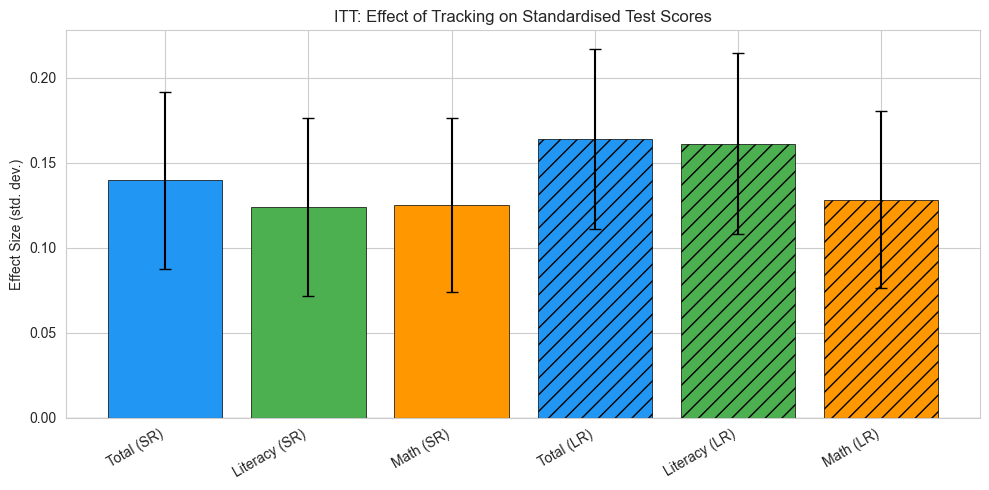

In [8]:
# Bar chart: ITT effect sizes with confidence intervals
fig, ax = plt.subplots(figsize=(10, 5))
df_eff = pd.DataFrame(diff_table)
labels = ['Total (SR)', 'Literacy (SR)', 'Math (SR)',
          'Total (LR)', 'Literacy (LR)', 'Math (LR)']
colors = ['#2196F3', '#4CAF50', '#FF9800'] * 2
hatches = [''] * 3 + ['//'] * 3

bars = ax.bar(range(len(labels)), df_eff['ATE'], color=colors, edgecolor='black', linewidth=0.5)
for bar, h in zip(bars, hatches):
    bar.set_hatch(h)

for i, row in df_eff.iterrows():
    c = st.loc[st['tracking'] == 0, row['outcome']].dropna()
    t = st.loc[st['tracking'] == 1, row['outcome']].dropna()
    se = np.sqrt(c.var()/len(c) + t.var()/len(t))
    ax.errorbar(i, row['ATE'], yerr=1.96*se, color='black', capsize=4, linewidth=1.5)

ax.set_xticks(range(len(labels)))
ax.set_xticklabels(labels, rotation=30, ha='right')
ax.set_ylabel('Effect Size (std. dev.)')
ax.set_title('ITT: Effect of Tracking on Standardised Test Scores')
ax.axhline(0, color='black', linewidth=0.8)
plt.tight_layout()
plt.show()

## 4. Heterogeneous Effects by Baseline Achievement

In [9]:
# Effect of tracking by baseline achievement quartile
conditions = [
    st['bottomquarter'] == 1,
    st['secondquarter'] == 1,
    st['thirdquarter'] == 1,
    st['topquarter'] == 1
]
choices = ['Q1 (bottom)', 'Q2', 'Q3', 'Q4 (top)']
st['quartile'] = np.select(conditions, choices, default='')
st.loc[st['quartile'] == '', 'quartile'] = np.nan

het = []
for q in ['Q1 (bottom)', 'Q2', 'Q3', 'Q4 (top)']:
    sub = st[st['quartile'] == q]
    for outcome_label, outcome_col in [('Total (SR)', 'z_totalscore'),
                                        ('Total (LR)', 'z_r2_totalscore')]:
        c = sub.loc[sub['tracking'] == 0, outcome_col].dropna()
        t = sub.loc[sub['tracking'] == 1, outcome_col].dropna()
        if len(c) > 1 and len(t) > 1:
            diff = t.mean() - c.mean()
            se = np.sqrt(c.var()/len(c) + t.var()/len(t))
            tstat, pval = stats.ttest_ind(c, t)
            het.append({'quartile': q, 'outcome': outcome_label,
                        'ATE': diff, 'SE': se, 'p_value': pval, 'N_ctrl': len(c), 'N_treat': len(t)})

het_df = pd.DataFrame(het)
print('=== Heterogeneous ITT by Baseline Quartile ===')
print(het_df.round(4).to_string(index=False))

=== Heterogeneous ITT by Baseline Quartile ===
   quartile    outcome    ATE     SE  p_value  N_ctrl  N_treat
Q1 (bottom) Total (SR) 0.1300 0.0444   0.0036     520      699
Q1 (bottom) Total (LR) 0.1157 0.0522   0.0272     503      663
         Q2 Total (SR) 0.1519 0.0466   0.0012     579      757
         Q2 Total (LR) 0.1229 0.0507   0.0153     538      719
         Q3 Total (SR) 0.1697 0.0499   0.0007     606      759
         Q3 Total (LR) 0.2337 0.0516   0.0000     565      728
   Q4 (top) Total (SR) 0.4493 0.0483   0.0000    1109      766
   Q4 (top) Total (LR) 0.4769 0.0453   0.0000    1055      718


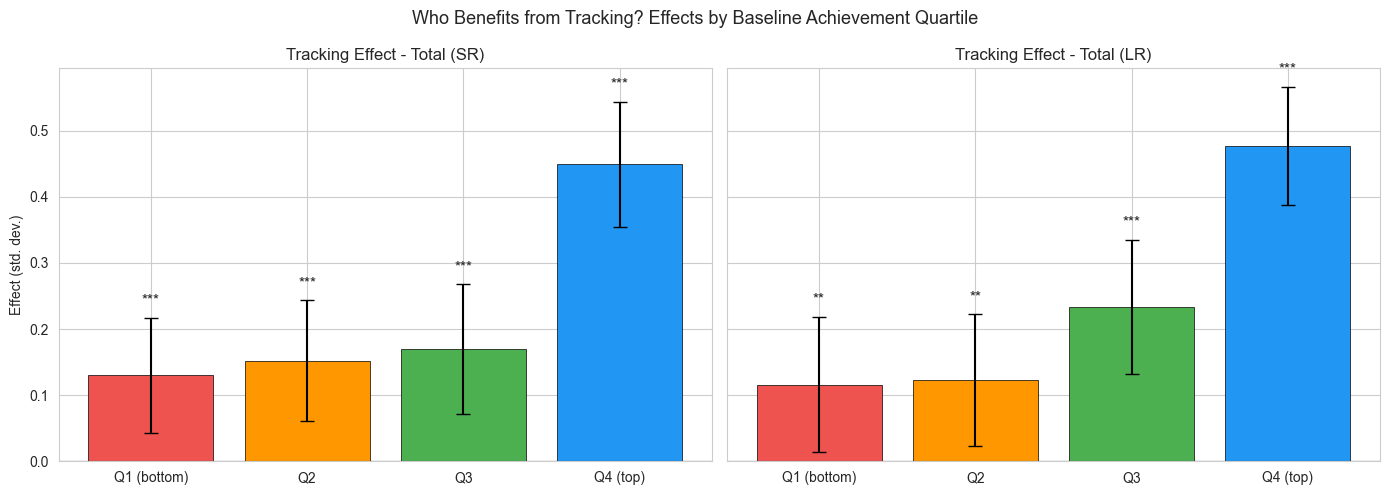

In [10]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5), sharey=True)

for ax, outcome in zip(axes, ['Total (SR)', 'Total (LR)']):
    sub = het_df[het_df['outcome'] == outcome]
    x = range(len(sub))
    ax.bar(x, sub['ATE'], yerr=1.96*sub['SE'], capsize=5,
           color=['#EF5350', '#FF9800', '#4CAF50', '#2196F3'], edgecolor='black', linewidth=0.5)
    ax.set_xticks(x)
    ax.set_xticklabels(sub['quartile'])
    ax.axhline(0, color='black', linewidth=0.8)
    ax.set_title(f'Tracking Effect - {outcome}')
    ax.set_ylabel('Effect (std. dev.)' if ax == axes[0] else '')
    for i, (_, row) in enumerate(sub.iterrows()):
        star = '***' if row['p_value'] < 0.01 else '**' if row['p_value'] < 0.05 else '*' if row['p_value'] < 0.1 else ''
        ax.text(i, row['ATE'] + 1.96*row['SE'] + 0.02, star, ha='center', fontsize=11)

fig.suptitle('Who Benefits from Tracking? Effects by Baseline Achievement Quartile', fontsize=13)
plt.tight_layout()
plt.show()

## 5. Heterogeneous Effects by Gender

In [11]:
gender_het = []
for gender_label, gender_val in [('Boys', 0.0), ('Girls', 1.0)]:
    for half_label, half_val in [('Bottom half', 1.0), ('Top half', 0.0)]:
        for out_label, out_col in [('Total (SR)', 'z_totalscore'), ('Total (LR)', 'z_r2_totalscore')]:
            sub = st[(st['girl'] == gender_val) & (st['bottomhalf'] == half_val)]
            c = sub.loc[sub['tracking'] == 0, out_col].dropna()
            t = sub.loc[sub['tracking'] == 1, out_col].dropna()
            if len(c) > 1 and len(t) > 1:
                diff = t.mean() - c.mean()
                se = np.sqrt(c.var()/len(c) + t.var()/len(t))
                _, pval = stats.ttest_ind(c, t)
                gender_het.append({'gender': gender_label, 'half': half_label,
                                   'outcome': out_label, 'ATE': diff, 'SE': se, 'p_value': pval})

gdf = pd.DataFrame(gender_het)
print('=== Gender x Achievement Half x Tracking ===')
print(gdf.round(4).to_string(index=False))

=== Gender x Achievement Half x Tracking ===
gender        half    outcome    ATE     SE  p_value
  Boys Bottom half Total (SR) 0.1054 0.0442   0.0176
  Boys Bottom half Total (LR) 0.0693 0.0499   0.1631
  Boys    Top half Total (SR) 0.1484 0.0526   0.0052
  Boys    Top half Total (LR) 0.1887 0.0529   0.0004
 Girls Bottom half Total (SR) 0.1840 0.0502   0.0003
 Girls Bottom half Total (LR) 0.1865 0.0556   0.0009
 Girls    Top half Total (SR) 0.2085 0.0555   0.0002
 Girls    Top half Total (LR) 0.2083 0.0520   0.0001


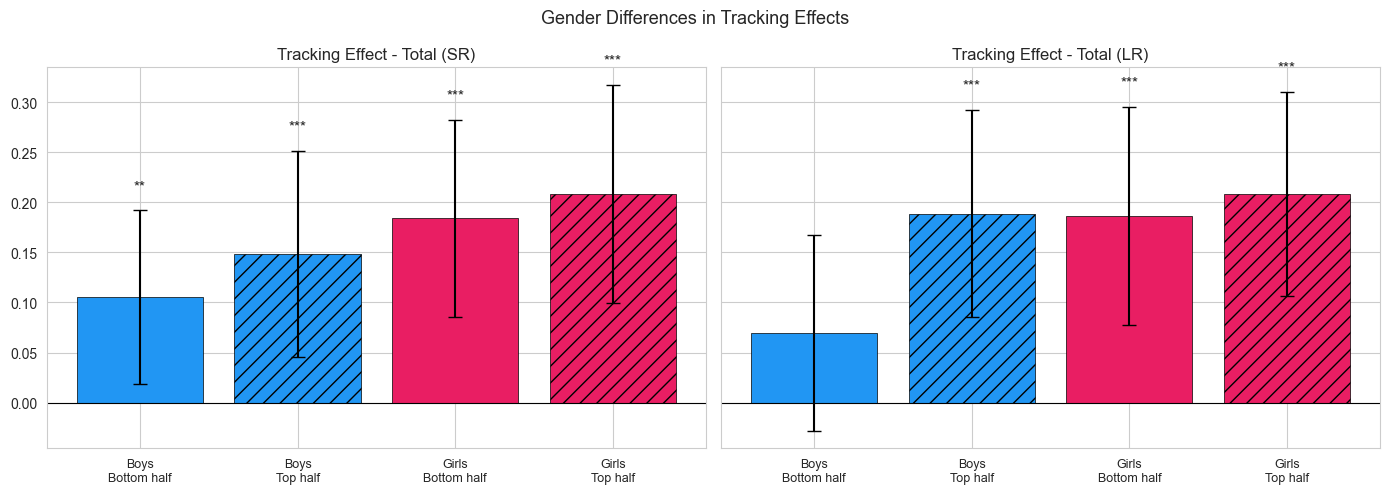

In [12]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5), sharey=True)

for ax, outcome in zip(axes, ['Total (SR)', 'Total (LR)']):
    sub = gdf[gdf['outcome'] == outcome]
    x = np.arange(len(sub))
    colors = ['#2196F3', '#2196F3', '#E91E63', '#E91E63']
    hatches = ['', '//', '', '//']
    bars = ax.bar(x, sub['ATE'], yerr=1.96*sub['SE'], capsize=5,
                  color=colors, edgecolor='black', linewidth=0.5)
    for bar, h in zip(bars, hatches):
        bar.set_hatch(h)
    ax.set_xticks(x)
    labels = [f"{r['gender']}\n{r['half']}" for _, r in sub.iterrows()]
    ax.set_xticklabels(labels, fontsize=9)
    ax.axhline(0, color='black', linewidth=0.8)
    ax.set_title(f'Tracking Effect - {outcome}')
    for i, (_, row) in enumerate(sub.iterrows()):
        star = '***' if row['p_value'] < 0.01 else '**' if row['p_value'] < 0.05 else '*' if row['p_value'] < 0.1 else ''
        offset = 1.96*row['SE'] + 0.02 if row['ATE'] >= 0 else -(1.96*row['SE'] + 0.06)
        ax.text(i, row['ATE'] + offset, star, ha='center', fontsize=11)

fig.suptitle('Gender Differences in Tracking Effects', fontsize=13)
plt.tight_layout()
plt.show()

## 6. Contract Teacher (ETP) Interactions

In [13]:
etp_het = []
for etp_label, etp_val in [('Civil servant', 0.0), ('Contract (ETP)', 1.0)]:
    for half_label, half_val in [('Bottom half', 1.0), ('Top half', 0.0)]:
        for out_label, out_col in [('Total (SR)', 'z_totalscore'), ('Total (LR)', 'z_r2_totalscore')]:
            sub = st[(st['etpteacher'] == etp_val) & (st['bottomhalf'] == half_val)]
            c = sub.loc[sub['tracking'] == 0, out_col].dropna()
            t = sub.loc[sub['tracking'] == 1, out_col].dropna()
            if len(c) > 1 and len(t) > 1:
                diff = t.mean() - c.mean()
                se = np.sqrt(c.var()/len(c) + t.var()/len(t))
                _, pval = stats.ttest_ind(c, t)
                etp_het.append({'teacher': etp_label, 'half': half_label,
                                'outcome': out_label, 'ATE': diff, 'SE': se, 'p_value': pval})

etp_df = pd.DataFrame(etp_het)
print('=== Tracking Effect by Teacher Type x Achievement Half ===')
print(etp_df.round(4).to_string(index=False))

=== Tracking Effect by Teacher Type x Achievement Half ===
       teacher        half    outcome    ATE     SE  p_value
 Civil servant Bottom half Total (SR) 0.0476 0.0462   0.2973
 Civil servant Bottom half Total (LR) 0.0993 0.0528   0.0607
 Civil servant    Top half Total (SR) 0.2242 0.0533   0.0000
 Civil servant    Top half Total (LR) 0.1918 0.0518   0.0002
Contract (ETP) Bottom half Total (SR) 0.2288 0.0472   0.0000
Contract (ETP) Bottom half Total (LR) 0.1551 0.0524   0.0031
Contract (ETP)    Top half Total (SR) 0.1603 0.0540   0.0031
Contract (ETP)    Top half Total (LR) 0.2341 0.0528   0.0000


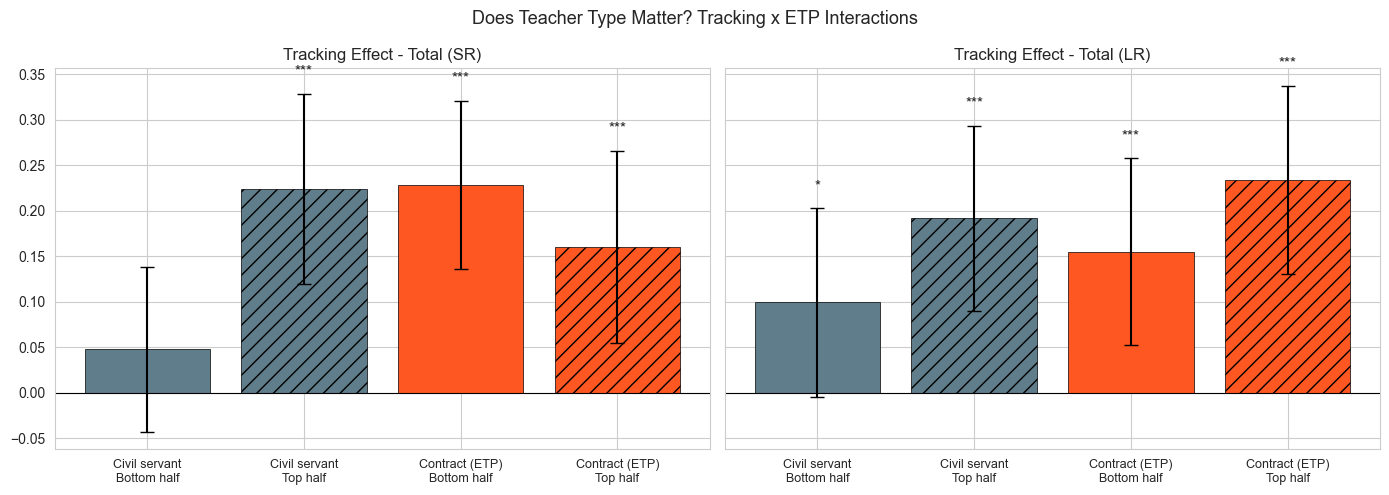

In [14]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5), sharey=True)

for ax, outcome in zip(axes, ['Total (SR)', 'Total (LR)']):
    sub = etp_df[etp_df['outcome'] == outcome]
    x = np.arange(len(sub))
    colors = ['#607D8B', '#607D8B', '#FF5722', '#FF5722']
    hatches = ['', '//', '', '//']
    bars = ax.bar(x, sub['ATE'], yerr=1.96*sub['SE'], capsize=5,
                  color=colors, edgecolor='black', linewidth=0.5)
    for bar, h in zip(bars, hatches):
        bar.set_hatch(h)
    ax.set_xticks(x)
    labels = [f"{r['teacher']}\n{r['half']}" for _, r in sub.iterrows()]
    ax.set_xticklabels(labels, fontsize=9)
    ax.axhline(0, color='black', linewidth=0.8)
    ax.set_title(f'Tracking Effect - {outcome}')
    for i, (_, row) in enumerate(sub.iterrows()):
        star = '***' if row['p_value'] < 0.01 else '**' if row['p_value'] < 0.05 else '*' if row['p_value'] < 0.1 else ''
        offset = 1.96*row['SE'] + 0.02 if row['ATE'] >= 0 else -(1.96*row['SE'] + 0.06)
        ax.text(i, row['ATE'] + offset, star, ha='center', fontsize=11)

fig.suptitle('Does Teacher Type Matter? Tracking x ETP Interactions', fontsize=13)
plt.tight_layout()
plt.show()

## 7. Peer Composition Effects (Non-tracking Schools)

In [15]:
# In non-tracking schools, students are randomly assigned to sections
nt = st[st['tracking'] == 0].copy()

peer_vars = ['rMEANstream_std_baselinemark', 'rSDstream_std_baselinemark',
             'MEANstream_std_mark', 'SDstream_std_mark']
outcome_vars = ['z_totalscore', 'z_litscore', 'z_mathscoreraw']

print('=== Correlations: Peer Composition -> Outcomes (Non-tracking schools) ===')
corr_rows = []
for p in peer_vars:
    for o in outcome_vars:
        sub = nt[[p, o]].dropna()
        if len(sub) > 2:
            r, pval = stats.pearsonr(sub[p], sub[o])
            corr_rows.append({'peer_var': p, 'outcome': o, 'corr': r, 'p_value': pval, 'N': len(sub)})

print(pd.DataFrame(corr_rows).round(4).to_string(index=False))

=== Correlations: Peer Composition -> Outcomes (Non-tracking schools) ===
                    peer_var        outcome    corr  p_value    N
rMEANstream_std_baselinemark   z_totalscore  0.0197   0.3542 2210
rMEANstream_std_baselinemark     z_litscore  0.0225   0.2906 2211
rMEANstream_std_baselinemark z_mathscoreraw  0.0114   0.5910 2210
  rSDstream_std_baselinemark   z_totalscore  0.0006   0.9786 2210
  rSDstream_std_baselinemark     z_litscore  0.0150   0.4802 2211
  rSDstream_std_baselinemark z_mathscoreraw -0.0171   0.4227 2210
         MEANstream_std_mark   z_totalscore  0.0888   0.0000 2210
         MEANstream_std_mark     z_litscore  0.0759   0.0004 2211
         MEANstream_std_mark z_mathscoreraw  0.0827   0.0001 2210
           SDstream_std_mark   z_totalscore  0.0087   0.6844 2210
           SDstream_std_mark     z_litscore  0.0266   0.2117 2211
           SDstream_std_mark z_mathscoreraw -0.0151   0.4789 2210


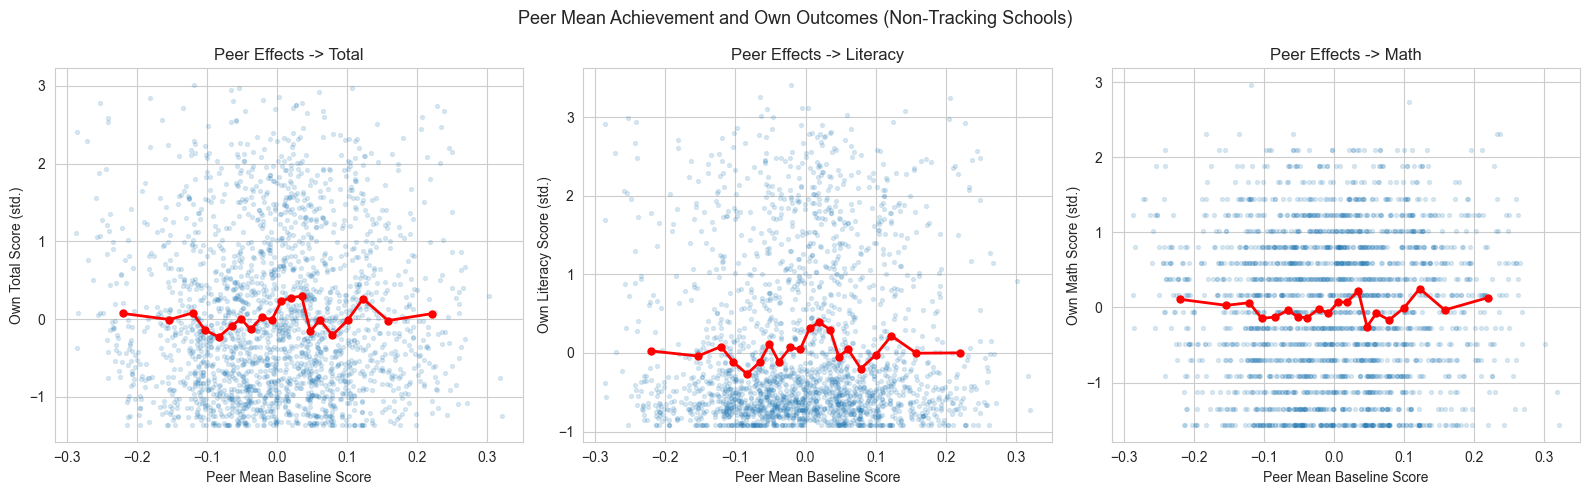

In [16]:
fig, axes = plt.subplots(1, 3, figsize=(16, 5))
for ax, (out_col, label) in zip(axes, [('z_totalscore', 'Total'), ('z_litscore', 'Literacy'), ('z_mathscoreraw', 'Math')]):
    sub = nt[['rMEANstream_std_baselinemark', out_col]].dropna()
    ax.scatter(sub['rMEANstream_std_baselinemark'], sub[out_col], alpha=0.15, s=8)
    sub['bin'] = pd.qcut(sub['rMEANstream_std_baselinemark'], 20, duplicates='drop')
    binned = sub.groupby('bin', observed=True)[out_col].mean()
    bin_x = sub.groupby('bin', observed=True)['rMEANstream_std_baselinemark'].mean()
    ax.plot(bin_x, binned, 'r-o', markersize=5, linewidth=2)
    ax.set_xlabel('Peer Mean Baseline Score')
    ax.set_ylabel(f'Own {label} Score (std.)')
    ax.set_title(f'Peer Effects -> {label}')

fig.suptitle('Peer Mean Achievement and Own Outcomes (Non-Tracking Schools)', fontsize=13)
plt.tight_layout()
plt.show()

## 8. Score Distributions: Tracking vs Non-Tracking

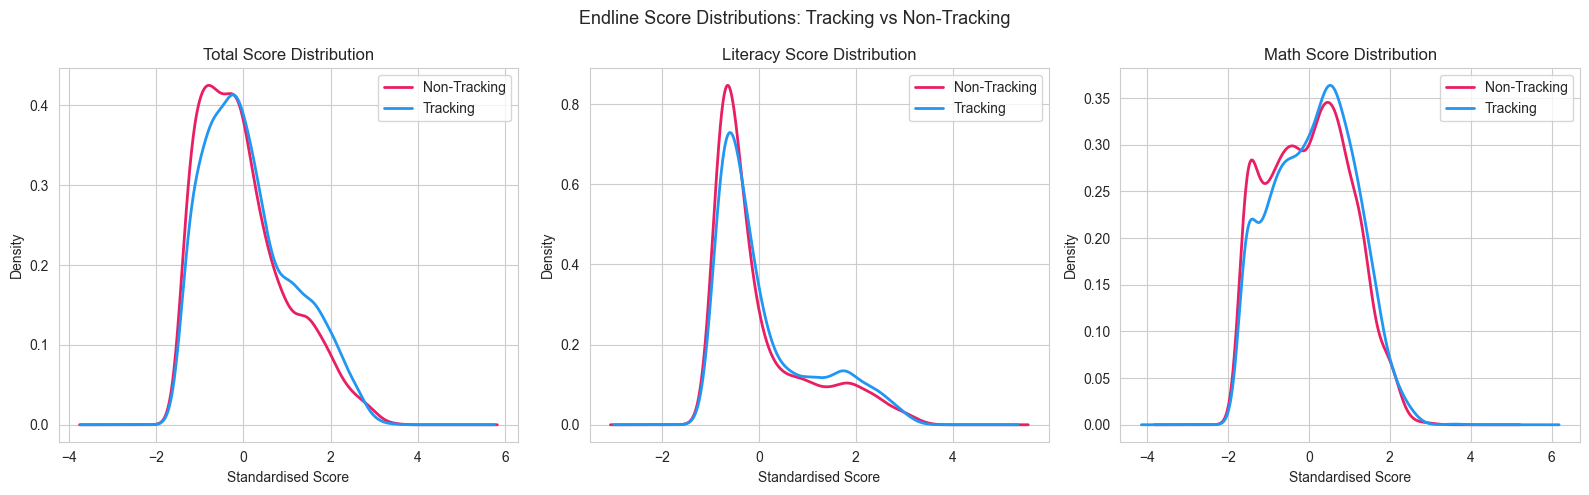

In [17]:
fig, axes = plt.subplots(1, 3, figsize=(16, 5))

for ax, (col, label) in zip(axes, [('z_totalscore', 'Total'), ('z_litscore', 'Literacy'), ('z_mathscoreraw', 'Math')]):
    for track_val, track_label, color in [(0, 'Non-Tracking', '#E91E63'), (1, 'Tracking', '#2196F3')]:
        data = st.loc[(st['tracking'] == track_val), col].dropna()
        data.plot.kde(ax=ax, label=track_label, color=color, linewidth=2)
    ax.set_title(f'{label} Score Distribution')
    ax.set_xlabel('Standardised Score')
    ax.legend()

fig.suptitle('Endline Score Distributions: Tracking vs Non-Tracking', fontsize=13)
plt.tight_layout()
plt.show()

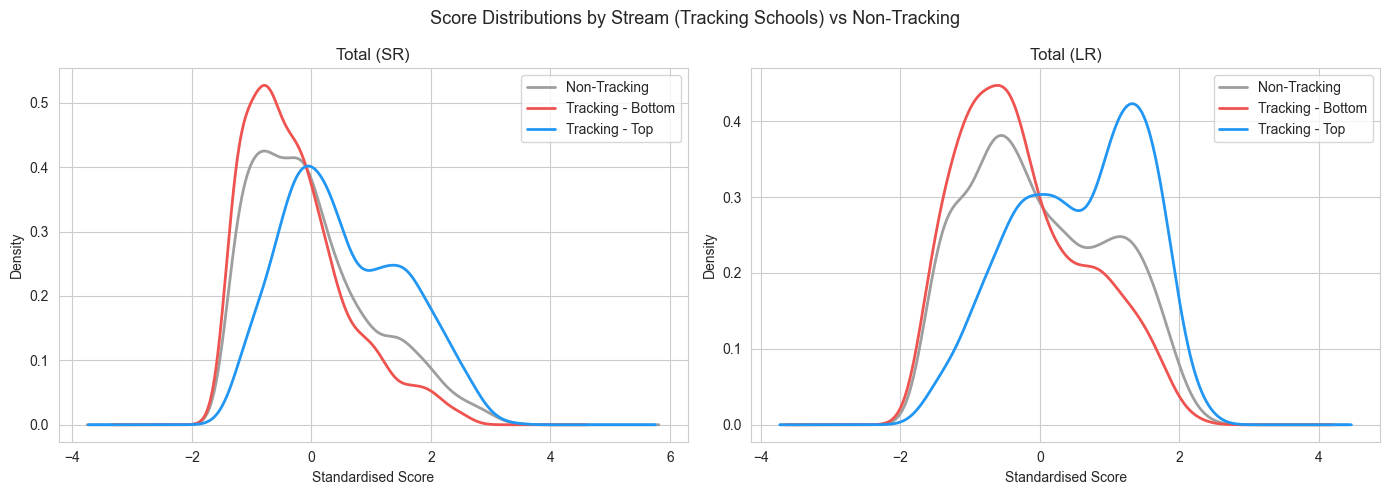

In [18]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

for ax, (col, label) in zip(axes, [('z_totalscore', 'Total (SR)'), ('z_r2_totalscore', 'Total (LR)')]):
    for grp, lbl, color in [
        ((st['tracking'] == 0), 'Non-Tracking', '#9E9E9E'),
        ((st['tracking'] == 1) & (st['bottomhalf'] == 1), 'Tracking - Bottom', '#EF5350'),
        ((st['tracking'] == 1) & (st['bottomhalf'] == 0), 'Tracking - Top', '#2196F3'),
    ]:
        data = st.loc[grp, col].dropna()
        if len(data) > 10:
            data.plot.kde(ax=ax, label=lbl, color=color, linewidth=2)
    ax.set_title(label)
    ax.set_xlabel('Standardised Score')
    ax.legend()

fig.suptitle('Score Distributions by Stream (Tracking Schools) vs Non-Tracking', fontsize=13)
plt.tight_layout()
plt.show()

## 9. Teacher & Student Attendance

In [19]:
print('=== Teacher Presence Rates ===')
print(tp.groupby(['tracking']).agg(
    presence_rate=('pres', 'mean'),
    inclass_rate=('inclass', 'mean'),
    n_obs=('pres', 'count')
).round(4))
print()
print('Teacher presence by tracking x stream:')
print(tp.groupby(['tracking', 'lowstream']).agg(
    presence=('pres', 'mean'),
    inclass=('inclass', 'mean'),
    n=('pres', 'count')
).round(4))
print()
print('Teacher presence by ETP status x tracking:')
print(tp.groupby(['tracking', 'etpteacher']).agg(
    presence=('pres', 'mean'),
    inclass=('inclass', 'mean'),
    n=('pres', 'count')
).round(4))

=== Teacher Presence Rates ===
          presence_rate  inclass_rate  n_obs
tracking                                    
0.0              0.8375        0.5093   1243
1.0              0.8399        0.5710   1212

Teacher presence by tracking x stream:
                    presence  inclass     n
tracking lowstream                         
0.0      0.0          0.8370   0.5053  1227
1.0      0.0          0.8576   0.5934   632
         1.0          0.8212   0.5434   565

Teacher presence by ETP status x tracking:
                     presence  inclass    n
tracking etpteacher                        
0.0      0.0           0.8248   0.4491  993
         1.0           0.8880   0.7480  250
1.0      0.0           0.8269   0.5223  965
         1.0           0.8907   0.7611  247


In [20]:
print('=== Student Presence Rates ===')
print(sp.groupby(['tracking', 'bottomhalf']).agg(
    presence_rate=('pres', 'mean'),
    n_obs=('pres', 'count')
).round(4))
print()
print('Student presence by gender x tracking:')
print(sp.groupby(['tracking', 'girl']).agg(
    presence=('pres', 'mean'),
    n=('pres', 'count')
).round(4))

=== Student Presence Rates ===
                     presence_rate  n_obs
tracking bottomhalf                      
0.0      0.0                0.8775  24098
         1.0                0.8589  18688
1.0      0.0                0.8744  13904
         1.0                0.8611  11663

Student presence by gender x tracking:
               presence      n
tracking girl                 
0.0      0.0     0.8655  26243
         1.0     0.8605  25123
1.0      0.0     0.8667  12951
         1.0     0.8705  12513


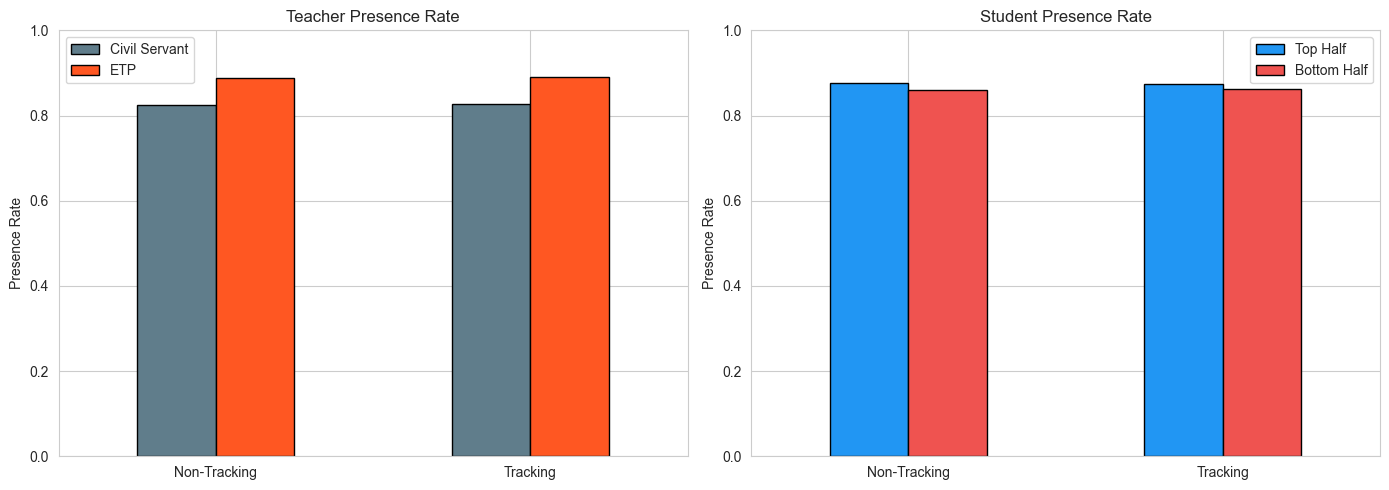

In [21]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

t_plot = tp.groupby(['tracking', 'etpteacher'])['pres'].mean().unstack()
t_plot.index = ['Non-Tracking', 'Tracking']
t_plot.columns = ['Civil Servant', 'ETP']
t_plot.plot(kind='bar', ax=axes[0], color=['#607D8B', '#FF5722'], edgecolor='black')
axes[0].set_title('Teacher Presence Rate')
axes[0].set_ylabel('Presence Rate')
axes[0].set_ylim(0, 1)
axes[0].tick_params(axis='x', rotation=0)

s_plot = sp.groupby(['tracking', 'bottomhalf'])['pres'].mean().unstack()
s_plot.index = ['Non-Tracking', 'Tracking']
s_plot.columns = ['Top Half', 'Bottom Half']
s_plot.plot(kind='bar', ax=axes[1], color=['#2196F3', '#EF5350'], edgecolor='black')
axes[1].set_title('Student Presence Rate')
axes[1].set_ylabel('Presence Rate')
axes[1].set_ylim(0, 1)
axes[1].tick_params(axis='x', rotation=0)

plt.tight_layout()
plt.show()

## 10. Correlation Heatmap — Key Variables

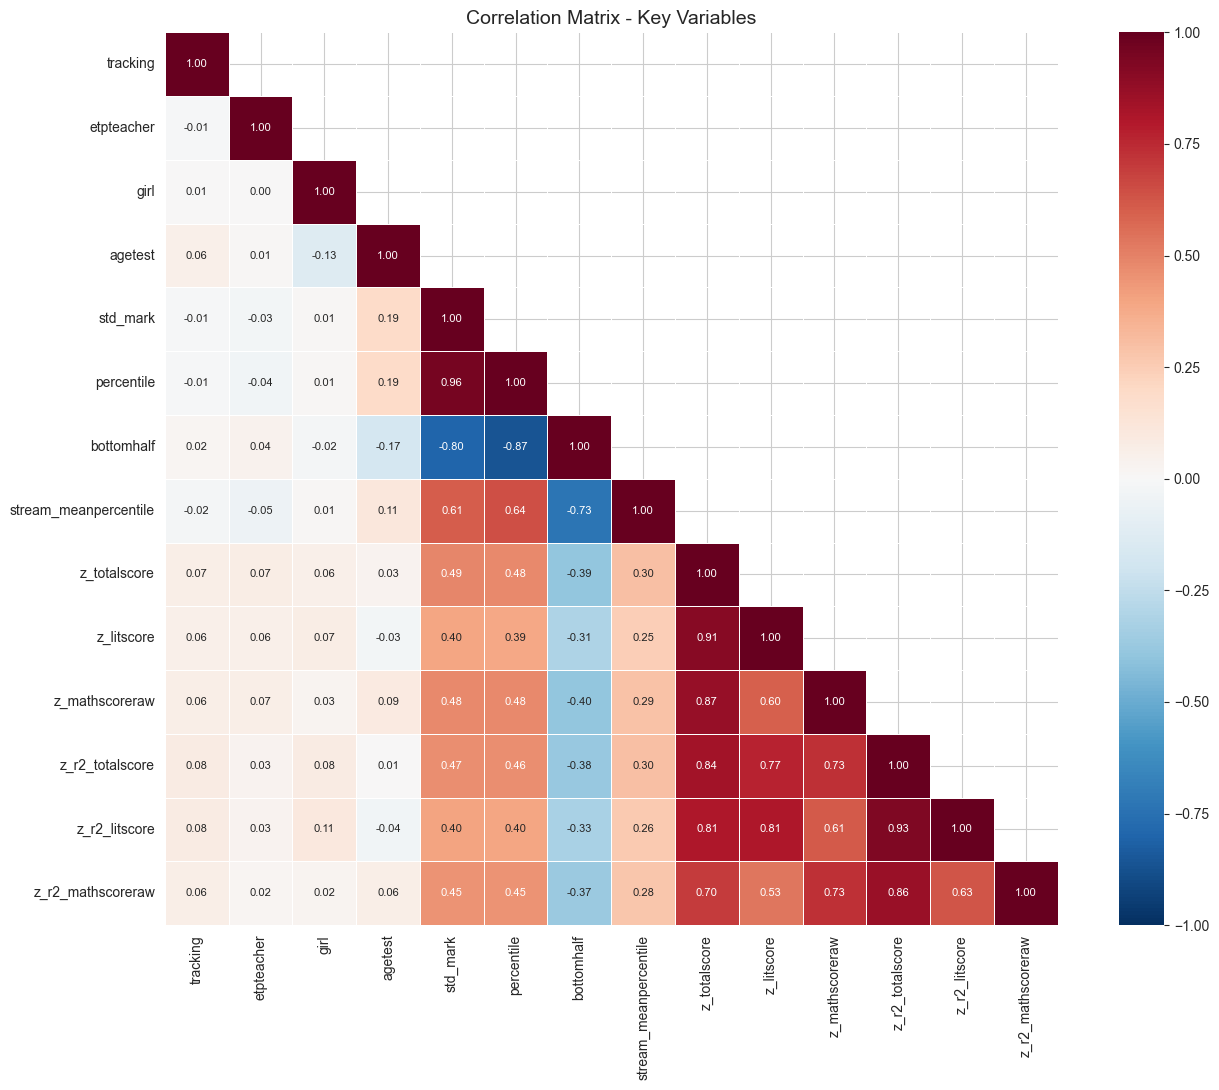

In [22]:
corr_vars = ['tracking', 'etpteacher', 'girl', 'agetest', 'std_mark', 'percentile',
             'bottomhalf', 'stream_meanpercentile',
             'z_totalscore', 'z_litscore', 'z_mathscoreraw',
             'z_r2_totalscore', 'z_r2_litscore', 'z_r2_mathscoreraw']

corr_matrix = st[corr_vars].corr()

fig, ax = plt.subplots(figsize=(14, 11))
mask = np.triu(np.ones_like(corr_matrix, dtype=bool), k=1)
sns.heatmap(corr_matrix, mask=mask, annot=True, fmt='.2f', cmap='RdBu_r',
            center=0, vmin=-1, vmax=1, square=True, linewidths=0.5, ax=ax,
            annot_kws={'size': 8})
ax.set_title('Correlation Matrix - Key Variables', fontsize=14)
plt.tight_layout()
plt.show()

## 11. RDD-style Plot: Effect by Baseline Percentile

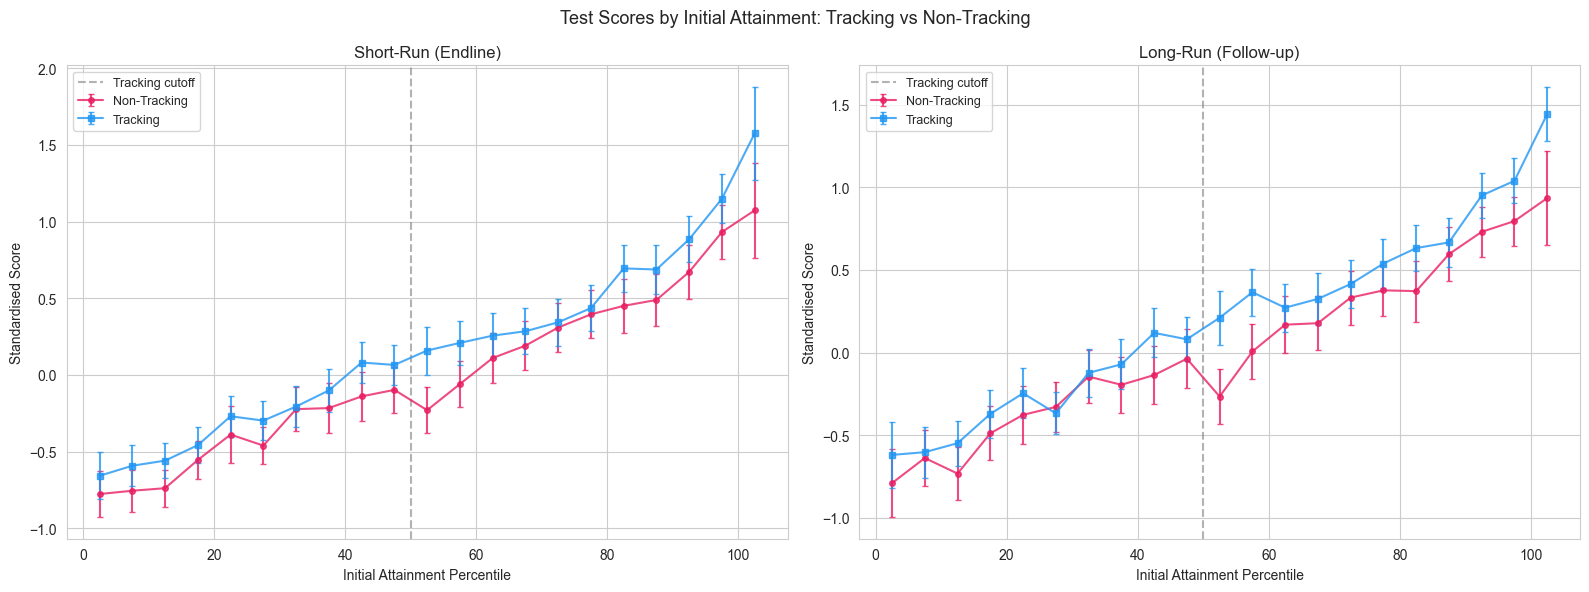

In [23]:
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

for ax, (col, title) in zip(axes, [('z_totalscore', 'Short-Run (Endline)'),
                                    ('z_r2_totalscore', 'Long-Run (Follow-up)')]):
    for track_val, label, color, marker in [(0, 'Non-Tracking', '#E91E63', 'o'),
                                             (1, 'Tracking', '#2196F3', 's')]:
        sub = st[st['tracking'] == track_val][['realpercentile', col]].dropna()
        if len(sub) < 10:
            continue
        sub['pctile_bin'] = (sub['realpercentile'] // 5) * 5 + 2.5
        binned = sub.groupby('pctile_bin')[col].agg(['mean', 'sem']).dropna()
        ax.errorbar(binned.index, binned['mean'], yerr=1.96*binned['sem'],
                    fmt=f'{marker}-', color=color, label=label, markersize=4,
                    capsize=2, alpha=0.8, linewidth=1.5)

    ax.axvline(50, color='gray', linestyle='--', alpha=0.6, label='Tracking cutoff')
    ax.set_xlabel('Initial Attainment Percentile')
    ax.set_ylabel('Standardised Score')
    ax.set_title(title)
    ax.legend(fontsize=9)

fig.suptitle('Test Scores by Initial Attainment: Tracking vs Non-Tracking', fontsize=13)
plt.tight_layout()
plt.show()

## 12. Short-Run vs Long-Run: Persistence of Effects

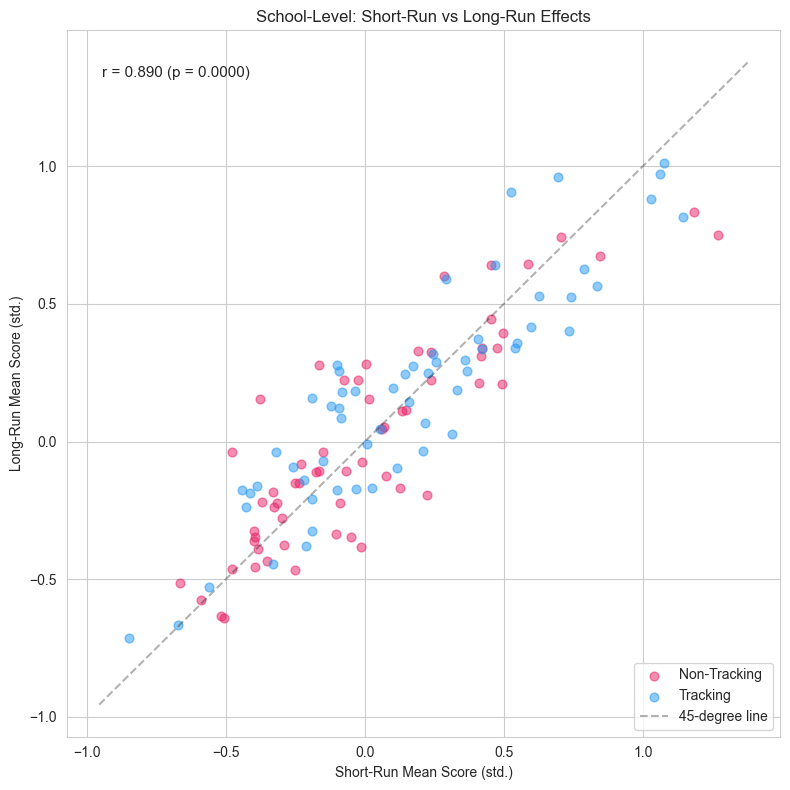

In [24]:
school = st.groupby(['schoolid', 'tracking']).agg(
    sr_total=('z_totalscore', 'mean'),
    lr_total=('z_r2_totalscore', 'mean'),
    n_students=('pupilid', 'count'),
    pct_girl=('girl', 'mean'),
    mean_age=('agetest', 'mean'),
    pct_etp=('etpteacher', 'mean'),
    mean_baseline=('std_mark', 'mean')
).reset_index()

fig, ax = plt.subplots(figsize=(8, 8))
for track_val, label, color in [(0, 'Non-Tracking', '#E91E63'), (1, 'Tracking', '#2196F3')]:
    sub = school[school['tracking'] == track_val].dropna(subset=['sr_total', 'lr_total'])
    ax.scatter(sub['sr_total'], sub['lr_total'], alpha=0.5, s=40, color=color, label=label)

lim = [min(ax.get_xlim()[0], ax.get_ylim()[0]), max(ax.get_xlim()[1], ax.get_ylim()[1])]
ax.plot(lim, lim, 'k--', alpha=0.3, label='45-degree line')
ax.set_xlabel('Short-Run Mean Score (std.)')
ax.set_ylabel('Long-Run Mean Score (std.)')
ax.set_title('School-Level: Short-Run vs Long-Run Effects')
ax.legend()

both = school.dropna(subset=['sr_total', 'lr_total'])
r, p = stats.pearsonr(both['sr_total'], both['lr_total'])
ax.text(0.05, 0.95, f'r = {r:.3f} (p = {p:.4f})', transform=ax.transAxes, fontsize=11, va='top')
plt.tight_layout()
plt.show()

## 13. Math vs Literacy: Differential Subject Effects

In [25]:
subject_het = []
for half_label, half_val in [('Bottom half', 1.0), ('Top half', 0.0), ('All', None)]:
    for subj_label, subj_col in [('Literacy (SR)', 'z_litscore'), ('Math (SR)', 'z_mathscoreraw'),
                                  ('Literacy (LR)', 'z_r2_litscore'), ('Math (LR)', 'z_r2_mathscoreraw')]:
        if half_val is not None:
            sub = st[st['bottomhalf'] == half_val]
        else:
            sub = st
        c = sub.loc[sub['tracking'] == 0, subj_col].dropna()
        t = sub.loc[sub['tracking'] == 1, subj_col].dropna()
        if len(c) > 1 and len(t) > 1:
            diff = t.mean() - c.mean()
            se = np.sqrt(c.var()/len(c) + t.var()/len(t))
            _, pval = stats.ttest_ind(c, t)
            subject_het.append({'group': half_label, 'subject': subj_label,
                                'ATE': diff, 'SE': se, 'p_value': pval})

subj_df = pd.DataFrame(subject_het)
print('=== Math vs Literacy Effects ===')
print(subj_df.round(4).to_string(index=False))

=== Math vs Literacy Effects ===
      group       subject    ATE     SE  p_value
Bottom half Literacy (SR) 0.0872 0.0307   0.0045
Bottom half     Math (SR) 0.1758 0.0363   0.0000
Bottom half Literacy (LR) 0.1117 0.0361   0.0020
Bottom half     Math (LR) 0.1202 0.0392   0.0022
   Top half Literacy (SR) 0.1826 0.0425   0.0000
   Top half     Math (SR) 0.1346 0.0344   0.0001
   Top half Literacy (LR) 0.2130 0.0401   0.0000
   Top half     Math (LR) 0.1348 0.0342   0.0001
        All Literacy (SR) 0.1239 0.0266   0.0000
        All     Math (SR) 0.1251 0.0262   0.0000
        All Literacy (LR) 0.1613 0.0272   0.0000
        All     Math (LR) 0.1283 0.0267   0.0000


## 14. Age Heterogeneity

In [26]:
st['age_group'] = pd.cut(st['agetest'], bins=[0, 8, 9, 10, 20], labels=['<=8', '9', '10', '>=11'])

age_het = []
for ag in ['<=8', '9', '10', '>=11']:
    sub = st[st['age_group'] == ag]
    for out_label, out_col in [('Total (SR)', 'z_totalscore'), ('Total (LR)', 'z_r2_totalscore')]:
        c = sub.loc[sub['tracking'] == 0, out_col].dropna()
        t = sub.loc[sub['tracking'] == 1, out_col].dropna()
        if len(c) > 5 and len(t) > 5:
            diff = t.mean() - c.mean()
            se = np.sqrt(c.var()/len(c) + t.var()/len(t))
            _, pval = stats.ttest_ind(c, t)
            age_het.append({'age_group': ag, 'outcome': out_label,
                            'ATE': diff, 'SE': se, 'p_value': pval, 'N': len(c)+len(t)})

age_df = pd.DataFrame(age_het)
print('=== Tracking Effect by Age Group ===')
print(age_df.round(4).to_string(index=False))

=== Tracking Effect by Age Group ===
age_group    outcome    ATE     SE  p_value    N
      <=8 Total (SR) 0.1770 0.0502   0.0004 1748
      <=8 Total (LR) 0.1878 0.0492   0.0001 1670
        9 Total (SR) 0.1709 0.0511   0.0009 1522
        9 Total (LR) 0.1797 0.0526   0.0007 1388
       10 Total (SR) 0.1262 0.0511   0.0137 1468
       10 Total (LR) 0.1493 0.0552   0.0069 1346
     >=11 Total (SR) 0.0245 0.0624   0.6948 1042
     >=11 Total (LR) 0.1351 0.0670   0.0447  930


## 15. District / Geographic Heterogeneity

In [27]:
dist_het = []
for dist_val, dist_label in [(1.0, 'Bungoma'), (0.0, 'Non-Bungoma')]:
    sub = st[st['bungoma'] == dist_val]
    for out_label, out_col in [('Total (SR)', 'z_totalscore'), ('Total (LR)', 'z_r2_totalscore')]:
        c = sub.loc[sub['tracking'] == 0, out_col].dropna()
        t = sub.loc[sub['tracking'] == 1, out_col].dropna()
        if len(c) > 1 and len(t) > 1:
            diff = t.mean() - c.mean()
            se = np.sqrt(c.var()/len(c) + t.var()/len(t))
            _, pval = stats.ttest_ind(c, t)
            dist_het.append({'district': dist_label, 'outcome': out_label,
                             'ATE': diff, 'SE': se, 'p_value': pval})

print('=== Tracking Effect by District ===')
print(pd.DataFrame(dist_het).round(4).to_string(index=False))

=== Tracking Effect by District ===
   district    outcome    ATE     SE  p_value
    Bungoma Total (SR) 0.0933 0.0487   0.0553
    Bungoma Total (LR) 0.1009 0.0541   0.0626
Non-Bungoma Total (SR) 0.1689 0.0313   0.0000
Non-Bungoma Total (LR) 0.1840 0.0313   0.0000


## 16. Regression-Based Estimates (with controls)

In [28]:
import statsmodels.formula.api as smf

# Drop rows missing key variables so groups align with model sample
reg_vars = ['z_totalscore', 'tracking', 'girl', 'percentile', 'agetest', 'etpteacher', 'bottomhalf', 'schoolid']
reg = st.dropna(subset=reg_vars).copy()
reg['tracking_bottomhalf'] = reg['tracking'] * reg['bottomhalf']

print('=== Model 1: Simple ITT ===')
m1 = smf.ols('z_totalscore ~ tracking', data=reg).fit(cov_type='cluster', cov_kwds={'groups': reg['schoolid']})
print(f'  tracking coef = {m1.params["tracking"]:.4f}, SE = {m1.bse["tracking"]:.4f}, p = {m1.pvalues["tracking"]:.4f}')

print('\n=== Model 2: ITT with controls ===')
m2 = smf.ols('z_totalscore ~ tracking + girl + percentile + agetest + etpteacher',
             data=reg).fit(cov_type='cluster', cov_kwds={'groups': reg['schoolid']})
print(m2.summary2().tables[1].to_string())

print('\n=== Model 3: Heterogeneous by achievement half ===')
m3 = smf.ols('z_totalscore ~ tracking + bottomhalf + tracking_bottomhalf + girl + percentile + agetest + etpteacher',
             data=reg).fit(cov_type='cluster', cov_kwds={'groups': reg['schoolid']})
print(m3.summary2().tables[1].to_string())
print(f'\n  Effect on top half:    tracking = {m3.params["tracking"]:.4f} (p={m3.pvalues["tracking"]:.4f})')
print(f'  Effect on bottom half: tracking + interaction = {m3.params["tracking"] + m3.params["tracking_bottomhalf"]:.4f}')

=== Model 1: Simple ITT ===
  tracking coef = 0.1477, SE = 0.0773, p = 0.0560

=== Model 2: ITT with controls ===
               Coef.  Std.Err.          z          P>|z|    [0.025    0.975]
Intercept  -0.665404  0.131190  -5.072059   3.935338e-07 -0.922532 -0.408276
tracking    0.174448  0.077037   2.264472   2.354512e-02  0.023458  0.325438
girl        0.082115  0.028819   2.849361   4.380709e-03  0.025631  0.138599
percentile  0.017512  0.000728  24.042751  9.940494e-128  0.016084  0.018939
agetest    -0.041261  0.013461  -3.065223   2.175080e-03 -0.067644 -0.014878
etpteacher  0.181895  0.037897   4.799703   1.589012e-06  0.107618  0.256172

=== Model 3: Heterogeneous by achievement half ===
                        Coef.  Std.Err.          z         P>|z|    [0.025    0.975]
Intercept           -0.920462  0.140075  -6.571198  4.991201e-11 -1.195004 -0.645920
tracking             0.193168  0.093018   2.076676  3.783151e-02  0.010856  0.375480
bottomhalf           0.208327  0.053365 

In [29]:
# Long-run regressions — use separate clean sample
reg_lr_vars = ['z_r2_totalscore', 'tracking', 'girl', 'percentile', 'agetest', 'etpteacher', 'bottomhalf', 'schoolid']
reg_lr = st.dropna(subset=reg_lr_vars).copy()
reg_lr['tracking_bottomhalf'] = reg_lr['tracking'] * reg_lr['bottomhalf']

print('=== Long-Run: Model 2 with controls ===')
m2lr = smf.ols('z_r2_totalscore ~ tracking + girl + percentile + agetest + etpteacher',
               data=reg_lr).fit(cov_type='cluster', cov_kwds={'groups': reg_lr['schoolid']})
print(m2lr.summary2().tables[1].to_string())

print('\n=== Long-Run: Model 3 heterogeneous ===')
m3lr = smf.ols('z_r2_totalscore ~ tracking + bottomhalf + tracking_bottomhalf + girl + percentile + agetest + etpteacher',
               data=reg_lr).fit(cov_type='cluster', cov_kwds={'groups': reg_lr['schoolid']})
print(m3lr.summary2().tables[1].to_string())
print(f'\n  LR Effect on top half:    {m3lr.params["tracking"]:.4f}')
print(f'  LR Effect on bottom half: {m3lr.params["tracking"] + m3lr.params["tracking_bottomhalf"]:.4f}')

=== Long-Run: Model 2 with controls ===
               Coef.  Std.Err.          z          P>|z|    [0.025    0.975]
Intercept  -0.433323  0.132404  -3.272746   1.065082e-03 -0.692830 -0.173817
tracking    0.176476  0.073361   2.405575   1.614705e-02  0.032690  0.320261
girl        0.126548  0.031435   4.025767   5.678993e-05  0.064938  0.188159
percentile  0.016883  0.000658  25.660712  3.210786e-145  0.015593  0.018172
agetest    -0.057292  0.013596  -4.214018   2.508669e-05 -0.083939 -0.030645
etpteacher  0.095202  0.033306   2.858387   4.258009e-03  0.029923  0.160480

=== Long-Run: Model 3 heterogeneous ===
                        Coef.  Std.Err.          z         P>|z|    [0.025    0.975]
Intercept           -0.666862  0.142671  -4.674113  2.952266e-06 -0.946492 -0.387231
tracking             0.216226  0.079896   2.706345  6.802832e-03  0.059633  0.372820
bottomhalf           0.205714  0.056664   3.630432  2.829469e-04  0.094655  0.316773
tracking_bottomhalf -0.084763  0.065230 

---

# Part II: Teacher Behavior as a Mechanism for Tracking Effects

**Research question:** Does tracking improve student outcomes by changing teacher behavior?

**Causal chain:** Tracking (random) &rarr; homogeneous classrooms &rarr; teachers adjust effort &rarr; student scores improve

**Identification:** Tracking is randomly assigned at the school level, giving clean causal estimates at each link in the chain.

## 18. Data Preparation: Linking Teachers to Students

In [30]:
# Aggregate teacher-level attendance to school-stream level
teacher_agg = tp.groupby(['schoolid', 'lowstream']).agg(
    teacher_pres=('pres', 'mean'),
    teacher_inclass=('inclass', 'mean'),
    n_teacher_visits=('pres', 'count'),
    n_teachers=('teacherid', 'nunique'),
    mean_experience=('yrstaught', 'mean'),
    pct_female_teacher=('female', 'mean')
).reset_index()

# Aggregate by teacher type within school-stream
teacher_by_type = tp.groupby(['schoolid', 'lowstream', 'etpteacher']).agg(
    pres=('pres', 'mean'),
    inclass=('inclass', 'mean'),
    n_visits=('pres', 'count')
).reset_index()

# Pivot to get ETP vs civil servant columns
etp_wide = teacher_by_type.pivot_table(
    index=['schoolid', 'lowstream'],
    columns='etpteacher',
    values=['pres', 'inclass'],
    aggfunc='mean'
)
etp_wide.columns = [f'{stat}_{"etp" if typ == 1.0 else "civil"}' for stat, typ in etp_wide.columns]
etp_wide = etp_wide.reset_index()

# Aggregate student attendance to school-stream level
student_attend = sp.groupby(['schoolid', 'bottomhalf']).agg(
    student_pres=('pres', 'mean'),
    n_student_visits=('pres', 'count')
).reset_index()

# Merge everything into student data
df = st.copy()
df = df.merge(teacher_agg, on=['schoolid', 'lowstream'], how='left')
df = df.merge(etp_wide, on=['schoolid', 'lowstream'], how='left')
df = df.merge(student_attend, on=['schoolid', 'bottomhalf'], how='left')

print(f'Merged dataset: {df.shape}')
print(f'Teacher data matched: {df["teacher_pres"].notna().sum()} / {len(df)}')
print(f'Student attend matched: {df["student_pres"].notna().sum()} / {len(df)}')
print()
print('New teacher variables:')
print(df[['teacher_pres', 'teacher_inclass', 'mean_experience',
          'pres_civil', 'pres_etp', 'inclass_civil', 'inclass_etp',
          'student_pres']].describe().round(4).T)

Merged dataset: (7022, 126)
Teacher data matched: 7022 / 7022
Student attend matched: 6431 / 7022

New teacher variables:
                  count     mean     std     min     25%      50%      75%  \
teacher_pres     7022.0   0.8466  0.1338  0.4000  0.7500   0.8750   0.9615   
teacher_inclass  7022.0   0.5800  0.2387  0.0000  0.4167   0.5714   0.7368   
mean_experience  6991.0  10.5949  7.4271  0.0000  2.4545  11.4000  15.7778   
pres_civil       5220.0   0.8158  0.1346  0.4000  0.7333   0.8333   0.9231   
pres_etp         5211.0   0.8958  0.1607  0.5000  0.7500   1.0000   1.0000   
inclass_civil    5220.0   0.4723  0.2119  0.0000  0.3333   0.4545   0.6154   
inclass_etp      5211.0   0.7546  0.2341  0.0000  0.6667   0.7500   1.0000   
student_pres     6431.0   0.8739  0.0732  0.6125  0.8361   0.8946   0.9270   

                     max  
teacher_pres      1.0000  
teacher_inclass   1.0000  
mean_experience  32.0769  
pres_civil        1.0000  
pres_etp          1.0000  
inclass_civil

## 19. First Stage: Does Tracking Change Teacher Behavior?

In [31]:
# First stage: effect of tracking on teacher behavior (school-stream level)
import statsmodels.formula.api as smf

# Collapse to school-stream level for teacher regressions
school_stream = tp.groupby(['schoolid', 'tracking', 'lowstream', 'etpteacher']).agg(
    pres=('pres', 'mean'),
    inclass=('inclass', 'mean'),
    yrstaught=('yrstaught', 'mean'),
    female=('female', 'mean'),
    n_visits=('pres', 'count')
).reset_index()

print('='*70)
print('FIRST STAGE: Effect of Tracking on Teacher Behavior')
print('='*70)

# Overall effect
for depvar, label in [('pres', 'Teacher Presence'), ('inclass', 'Teacher In-Class')]:
    print(f'\n--- {label} ---')
    m = smf.ols(f'{depvar} ~ tracking', data=school_stream).fit(
        cov_type='cluster', cov_kwds={'groups': school_stream['schoolid']})
    ctrl_mean = school_stream.loc[school_stream['tracking'] == 0, depvar].mean()
    print(f'  Control mean: {ctrl_mean:.4f}')
    print(f'  Tracking:     {m.params["tracking"]:+.4f} (SE={m.bse["tracking"]:.4f}, p={m.pvalues["tracking"]:.4f})')

# By teacher type
print('\n' + '='*70)
print('FIRST STAGE BY TEACHER TYPE')
print('='*70)
for etp_val, etp_label in [(0.0, 'Civil Servant'), (1.0, 'Contract (ETP)')]:
    sub = school_stream[school_stream['etpteacher'] == etp_val]
    print(f'\n  [{etp_label}]')
    for depvar, label in [('pres', 'Presence'), ('inclass', 'In-Class')]:
        m = smf.ols(f'{depvar} ~ tracking', data=sub).fit(
            cov_type='cluster', cov_kwds={'groups': sub['schoolid']})
        ctrl_mean = sub.loc[sub['tracking'] == 0, depvar].mean()
        print(f'    {label:12s}: ctrl={ctrl_mean:.3f}, tracking={m.params["tracking"]:+.4f} '
              f'(SE={m.bse["tracking"]:.4f}, p={m.pvalues["tracking"]:.4f})')

FIRST STAGE: Effect of Tracking on Teacher Behavior

--- Teacher Presence ---
  Control mean: 0.8470
  Tracking:     +0.0128 (SE=0.0166, p=0.4413)

--- Teacher In-Class ---
  Control mean: 0.5979
  Tracking:     +0.0504 (SE=0.0308, p=0.1019)

FIRST STAGE BY TEACHER TYPE

  [Civil Servant]
    Presence    : ctrl=0.815, tracking=+0.0058 (SE=0.0231, p=0.8013)
    In-Class    : ctrl=0.453, tracking=+0.0797 (SE=0.0359, p=0.0262)

  [Contract (ETP)]
    Presence    : ctrl=0.879, tracking=+0.0197 (SE=0.0277, p=0.4773)
    In-Class    : ctrl=0.743, tracking=+0.0211 (SE=0.0396, p=0.5934)


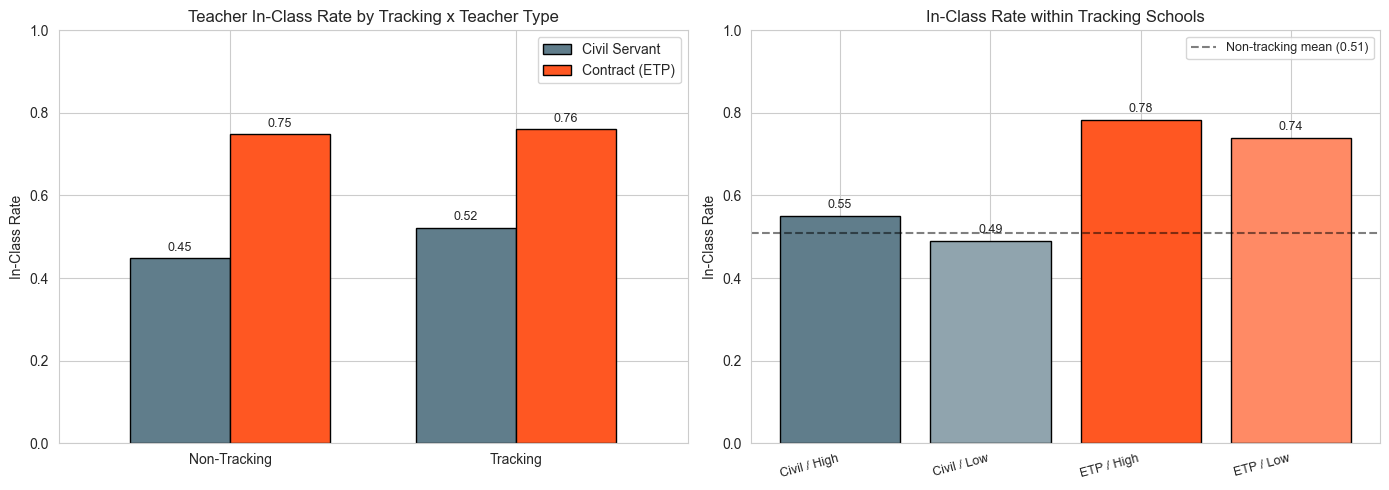

In [32]:
# Visualise: Teacher in-class rates by tracking x teacher type x stream
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Panel A: In-class rate by tracking x teacher type
plot_data = tp.groupby(['tracking', 'etpteacher'])['inclass'].mean().unstack()
plot_data.index = ['Non-Tracking', 'Tracking']
plot_data.columns = ['Civil Servant', 'Contract (ETP)']
plot_data.plot(kind='bar', ax=axes[0], color=['#607D8B', '#FF5722'], edgecolor='black', width=0.7)
axes[0].set_title('Teacher In-Class Rate by Tracking x Teacher Type')
axes[0].set_ylabel('In-Class Rate')
axes[0].set_ylim(0, 1)
axes[0].tick_params(axis='x', rotation=0)
# Add value labels
for container in axes[0].containers:
    axes[0].bar_label(container, fmt='%.2f', fontsize=9, padding=3)

# Panel B: In-class rate by tracking x stream (tracking schools only)
track_data = tp[tp['tracking'] == 1].copy()
track_data['group'] = track_data.apply(
    lambda r: f'{"ETP" if r["etpteacher"]==1 else "Civil"} / {"Low" if r["lowstream"]==1 else "High"}', axis=1)
order = ['Civil / High', 'Civil / Low', 'ETP / High', 'ETP / Low']
means = track_data.groupby('group')['inclass'].mean().reindex(order)
colors = ['#607D8B', '#90A4AE', '#FF5722', '#FF8A65']
bars = axes[1].bar(range(len(means)), means.values, color=colors, edgecolor='black')
axes[1].set_xticks(range(len(means)))
axes[1].set_xticklabels(order, rotation=15, ha='right', fontsize=9)
axes[1].set_title('In-Class Rate within Tracking Schools')
axes[1].set_ylabel('In-Class Rate')
axes[1].set_ylim(0, 1)
for i, v in enumerate(means.values):
    axes[1].text(i, v + 0.02, f'{v:.2f}', ha='center', fontsize=9)

# Add control mean reference line
ctrl_inclass = tp[tp['tracking'] == 0]['inclass'].mean()
axes[1].axhline(ctrl_inclass, color='black', linestyle='--', alpha=0.5, label=f'Non-tracking mean ({ctrl_inclass:.2f})')
axes[1].legend(fontsize=9)

plt.tight_layout()
plt.show()

## 20. Reduced Form: Teacher Effort &rarr; Student Outcomes (OLS)

In [33]:
# OLS: teacher in-class rate -> student scores (with controls)
# Note: these are NOT causal — just showing the reduced-form relationship

reg_cols = ['z_totalscore', 'z_litscore', 'z_mathscoreraw',
            'z_r2_totalscore', 'z_r2_litscore', 'z_r2_mathscoreraw',
            'teacher_inclass', 'teacher_pres', 'mean_experience',
            'tracking', 'girl', 'percentile', 'agetest', 'etpteacher',
            'bottomhalf', 'schoolid', 'student_pres']
reg_df = df.dropna(subset=['z_totalscore', 'teacher_inclass', 'girl',
                            'percentile', 'agetest', 'etpteacher', 'schoolid']).copy()

print('='*70)
print('OLS: Teacher In-Class Rate -> Student Scores')
print('='*70)

for dep, label in [('z_totalscore', 'Total (SR)'), ('z_r2_totalscore', 'Total (LR)')]:
    sub = reg_df.dropna(subset=[dep])
    print(f'\n--- {label} (N={len(sub)}) ---')

    # Without tracking control
    m1 = smf.ols(f'{dep} ~ teacher_inclass + girl + percentile + agetest + etpteacher',
                 data=sub).fit(cov_type='cluster', cov_kwds={'groups': sub['schoolid']})
    print(f'  [No tracking ctrl]  teacher_inclass: {m1.params["teacher_inclass"]:+.4f} '
          f'(SE={m1.bse["teacher_inclass"]:.4f}, p={m1.pvalues["teacher_inclass"]:.4f})')

    # With tracking control
    m2 = smf.ols(f'{dep} ~ teacher_inclass + tracking + girl + percentile + agetest + etpteacher',
                 data=sub).fit(cov_type='cluster', cov_kwds={'groups': sub['schoolid']})
    print(f'  [With tracking ctrl] teacher_inclass: {m2.params["teacher_inclass"]:+.4f} '
          f'(SE={m2.bse["teacher_inclass"]:.4f}, p={m2.pvalues["teacher_inclass"]:.4f})')
    print(f'                       tracking:        {m2.params["tracking"]:+.4f} '
          f'(SE={m2.bse["tracking"]:.4f}, p={m2.pvalues["tracking"]:.4f})')

OLS: Teacher In-Class Rate -> Student Scores

--- Total (SR) (N=5269) ---
  [No tracking ctrl]  teacher_inclass: +0.2143 (SE=0.1469, p=0.1444)
  [With tracking ctrl] teacher_inclass: +0.0951 (SE=0.1456, p=0.5135)
                       tracking:        +0.1591 (SE=0.0783, p=0.0422)

--- Total (LR) (N=4573) ---
  [No tracking ctrl]  teacher_inclass: +0.1619 (SE=0.1379, p=0.2406)
  [With tracking ctrl] teacher_inclass: +0.0330 (SE=0.1367, p=0.8092)
                       tracking:        +0.1737 (SE=0.0752, p=0.0208)


## 21. IV Estimation: Tracking as Instrument for Teacher In-Class Time

In [34]:
# IV / 2SLS: instrument teacher_inclass with tracking
from statsmodels.sandbox.regression.gmm import IV2SLS

print('='*70)
print('IV / 2SLS: Tracking -> Teacher In-Class -> Student Scores')
print('='*70)

for dep, label in [('z_totalscore', 'Total (SR)'), ('z_r2_totalscore', 'Total (LR)')]:
    sub = reg_df.dropna(subset=[dep]).copy()

    # First stage
    fs = smf.ols('teacher_inclass ~ tracking + girl + percentile + agetest + etpteacher',
                 data=sub).fit(cov_type='cluster', cov_kwds={'groups': sub['schoolid']})

    print(f'\n--- {label} (N={len(sub)}) ---')
    print(f'  First stage: tracking -> teacher_inclass = {fs.params["tracking"]:+.4f} '
          f'(SE={fs.bse["tracking"]:.4f}, p={fs.pvalues["tracking"]:.4f}, F={fs.fvalue:.2f})')

    # Manual 2SLS
    sub['teacher_inclass_hat'] = fs.fittedvalues
    ss = smf.ols(f'{dep} ~ teacher_inclass_hat + girl + percentile + agetest + etpteacher',
                 data=sub).fit(cov_type='cluster', cov_kwds={'groups': sub['schoolid']})
    print(f'  Second stage: teacher_inclass_hat -> {dep}')
    print(f'    coef = {ss.params["teacher_inclass_hat"]:+.4f} '
          f'(SE={ss.bse["teacher_inclass_hat"]:.4f}, p={ss.pvalues["teacher_inclass_hat"]:.4f})')

    # Reduced form for comparison
    rf = smf.ols(f'{dep} ~ tracking + girl + percentile + agetest + etpteacher',
                 data=sub).fit(cov_type='cluster', cov_kwds={'groups': sub['schoolid']})
    print(f'  Reduced form: tracking -> {dep} = {rf.params["tracking"]:+.4f}')
    print(f'  Implied IV = reduced_form / first_stage = {rf.params["tracking"] / fs.params["tracking"]:+.4f}')

IV / 2SLS: Tracking -> Teacher In-Class -> Student Scores

--- Total (SR) (N=5269) ---
  First stage: tracking -> teacher_inclass = +0.1611 (SE=0.0343, p=0.0000, F=11.70)
  Second stage: teacher_inclass_hat -> z_totalscore
    coef = +1.0830 (SE=0.4783, p=0.0235)
  Reduced form: tracking -> z_totalscore = +0.1744
  Implied IV = reduced_form / first_stage = +1.0830

--- Total (LR) (N=4573) ---
  First stage: tracking -> teacher_inclass = +0.1595 (SE=0.0344, p=0.0000, F=11.32)
  Second stage: teacher_inclass_hat -> z_r2_totalscore
    coef = +1.1223 (SE=0.4633, p=0.0154)
  Reduced form: tracking -> z_r2_totalscore = +0.1790
  Implied IV = reduced_form / first_stage = +1.1223


## 22. Triple Interaction: Tracking x Teacher Type x Student Ability

In [35]:
# Full interaction model: tracking x etpteacher x bottomhalf
print('='*70)
print('TRIPLE INTERACTION: Tracking x ETP x Bottom Half')
print('='*70)

for dep, label in [('z_totalscore', 'Total (SR)'), ('z_r2_totalscore', 'Total (LR)')]:
    sub = reg_df.dropna(subset=[dep]).copy()
    sub['track_etp'] = sub['tracking'] * sub['etpteacher']
    sub['track_bottom'] = sub['tracking'] * sub['bottomhalf']
    sub['etp_bottom'] = sub['etpteacher'] * sub['bottomhalf']
    sub['track_etp_bottom'] = sub['tracking'] * sub['etpteacher'] * sub['bottomhalf']

    m = smf.ols(f'{dep} ~ tracking + etpteacher + bottomhalf + '
                f'track_etp + track_bottom + etp_bottom + track_etp_bottom + '
                f'girl + percentile + agetest',
                data=sub).fit(cov_type='cluster', cov_kwds={'groups': sub['schoolid']})

    print(f'\n--- {label} (N={len(sub)}) ---')
    # Show key coefficients
    key_vars = ['tracking', 'etpteacher', 'bottomhalf', 'track_etp',
                'track_bottom', 'etp_bottom', 'track_etp_bottom']
    for v in key_vars:
        star = '***' if m.pvalues[v] < 0.01 else '**' if m.pvalues[v] < 0.05 else '*' if m.pvalues[v] < 0.1 else ''
        print(f'  {v:25s}: {m.params[v]:+.4f} (SE={m.bse[v]:.4f}) {star}')

    # Compute marginal effects for each group
    print(f'\n  Marginal tracking effects:')
    groups = [
        ('Civil servant, Top half',    m.params['tracking']),
        ('Civil servant, Bottom half', m.params['tracking'] + m.params['track_bottom']),
        ('ETP teacher, Top half',      m.params['tracking'] + m.params['track_etp']),
        ('ETP teacher, Bottom half',   m.params['tracking'] + m.params['track_etp'] +
                                       m.params['track_bottom'] + m.params['track_etp_bottom']),
    ]
    for name, effect in groups:
        print(f'    {name:35s}: {effect:+.4f}')

TRIPLE INTERACTION: Tracking x ETP x Bottom Half

--- Total (SR) (N=5269) ---
  tracking                 : +0.2282 (SE=0.1187) *
  etpteacher               : +0.2792 (SE=0.0636) ***
  bottomhalf               : +0.3557 (SE=0.0622) ***
  track_etp                : -0.0653 (SE=0.1478) 
  track_bottom             : -0.1828 (SE=0.1228) 
  etp_bottom               : -0.2800 (SE=0.0734) ***
  track_etp_bottom         : +0.2690 (SE=0.2196) 

  Marginal tracking effects:
    Civil servant, Top half            : +0.2282
    Civil servant, Bottom half         : +0.0454
    ETP teacher, Top half              : +0.1629
    ETP teacher, Bottom half           : +0.2491

--- Total (LR) (N=4573) ---
  tracking                 : +0.2063 (SE=0.0978) **
  etpteacher               : +0.1722 (SE=0.0579) ***
  bottomhalf               : +0.3113 (SE=0.0666) ***
  track_etp                : +0.0260 (SE=0.1260) 
  track_bottom             : -0.0982 (SE=0.1185) 
  etp_bottom               : -0.2155 (SE=0.0682) 

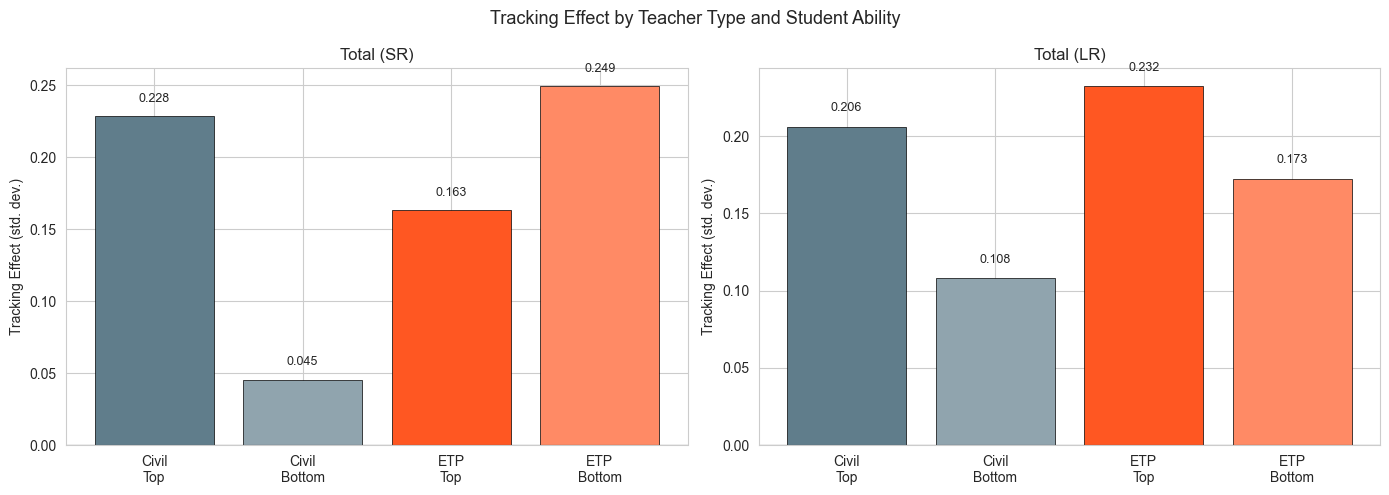

In [36]:
# Visualise marginal tracking effects across groups
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

for ax, dep, label in [(axes[0], 'z_totalscore', 'Total (SR)'),
                        (axes[1], 'z_r2_totalscore', 'Total (LR)')]:
    sub = reg_df.dropna(subset=[dep]).copy()
    sub['track_etp'] = sub['tracking'] * sub['etpteacher']
    sub['track_bottom'] = sub['tracking'] * sub['bottomhalf']
    sub['etp_bottom'] = sub['etpteacher'] * sub['bottomhalf']
    sub['track_etp_bottom'] = sub['tracking'] * sub['etpteacher'] * sub['bottomhalf']

    m = smf.ols(f'{dep} ~ tracking + etpteacher + bottomhalf + '
                f'track_etp + track_bottom + etp_bottom + track_etp_bottom + '
                f'girl + percentile + agetest',
                data=sub).fit(cov_type='cluster', cov_kwds={'groups': sub['schoolid']})

    groups = {
        'Civil\nTop': m.params['tracking'],
        'Civil\nBottom': m.params['tracking'] + m.params['track_bottom'],
        'ETP\nTop': m.params['tracking'] + m.params['track_etp'],
        'ETP\nBottom': m.params['tracking'] + m.params['track_etp'] +
                       m.params['track_bottom'] + m.params['track_etp_bottom'],
    }

    x = np.arange(len(groups))
    colors = ['#607D8B', '#90A4AE', '#FF5722', '#FF8A65']
    ax.bar(x, list(groups.values()), color=colors, edgecolor='black', linewidth=0.5)
    ax.set_xticks(x)
    ax.set_xticklabels(list(groups.keys()), fontsize=10)
    ax.axhline(0, color='black', linewidth=0.8)
    ax.set_ylabel('Tracking Effect (std. dev.)')
    ax.set_title(label)
    for i, v in enumerate(groups.values()):
        ax.text(i, v + 0.01 if v >= 0 else v - 0.03, f'{v:.3f}', ha='center', fontsize=9)

fig.suptitle('Tracking Effect by Teacher Type and Student Ability', fontsize=13)
plt.tight_layout()
plt.show()

## 23. Mediation Analysis: How Much of Tracking Works Through Teacher Effort?

In [37]:
# Mediation decomposition:
# Total effect = Direct effect (tracking -> scores) + Indirect effect (tracking -> teacher -> scores)
# Method: compare tracking coefficient with and without teacher controls

print('='*70)
print('MEDIATION: Does controlling for teacher effort reduce the tracking effect?')
print('='*70)

for dep, label in [('z_totalscore', 'Total (SR)'), ('z_r2_totalscore', 'Total (LR)')]:
    sub = reg_df.dropna(subset=[dep, 'teacher_inclass', 'student_pres']).copy()
    controls = 'girl + percentile + agetest + etpteacher'

    # Total effect (no mediator)
    m_total = smf.ols(f'{dep} ~ tracking + {controls}', data=sub).fit(
        cov_type='cluster', cov_kwds={'groups': sub['schoolid']})

    # Controlling for teacher in-class
    m_teacher = smf.ols(f'{dep} ~ tracking + teacher_inclass + {controls}', data=sub).fit(
        cov_type='cluster', cov_kwds={'groups': sub['schoolid']})

    # Controlling for student attendance
    m_student = smf.ols(f'{dep} ~ tracking + student_pres + {controls}', data=sub).fit(
        cov_type='cluster', cov_kwds={'groups': sub['schoolid']})

    # Controlling for both
    m_both = smf.ols(f'{dep} ~ tracking + teacher_inclass + student_pres + {controls}', data=sub).fit(
        cov_type='cluster', cov_kwds={'groups': sub['schoolid']})

    total = m_total.params['tracking']
    after_teacher = m_teacher.params['tracking']
    after_student = m_student.params['tracking']
    after_both = m_both.params['tracking']

    print(f'\n--- {label} (N={len(sub)}) ---')
    print(f'  Total tracking effect:                 {total:+.4f} (p={m_total.pvalues["tracking"]:.4f})')
    print(f'  After controlling for teacher in-class: {after_teacher:+.4f} (p={m_teacher.pvalues["tracking"]:.4f})')
    print(f'    -> Explained by teacher effort: {(1 - after_teacher/total)*100:.1f}%')
    print(f'  After controlling for student attend:   {after_student:+.4f} (p={m_student.pvalues["tracking"]:.4f})')
    print(f'    -> Explained by student attendance: {(1 - after_student/total)*100:.1f}%')
    print(f'  After controlling for both:             {after_both:+.4f} (p={m_both.pvalues["tracking"]:.4f})')
    print(f'    -> Total explained: {(1 - after_both/total)*100:.1f}%')
    print(f'  Teacher in-class coef in full model:   {m_both.params["teacher_inclass"]:+.4f} '
          f'(p={m_both.pvalues["teacher_inclass"]:.4f})')
    print(f'  Student attend coef in full model:     {m_both.params["student_pres"]:+.4f} '
          f'(p={m_both.pvalues["student_pres"]:.4f})')

MEDIATION: Does controlling for teacher effort reduce the tracking effect?

--- Total (SR) (N=5269) ---
  Total tracking effect:                 +0.1744 (p=0.0235)
  After controlling for teacher in-class: +0.1591 (p=0.0422)
    -> Explained by teacher effort: 8.8%
  After controlling for student attend:   +0.1945 (p=0.0083)
    -> Explained by student attendance: -11.5%
  After controlling for both:             +0.1800 (p=0.0179)
    -> Total explained: -3.2%
  Teacher in-class coef in full model:   +0.0900 (p=0.5153)
  Student attend coef in full model:     +2.0394 (p=0.0000)

--- Total (LR) (N=4573) ---
  Total tracking effect:                 +0.1790 (p=0.0154)
  After controlling for teacher in-class: +0.1737 (p=0.0208)
    -> Explained by teacher effort: 2.9%
  After controlling for student attend:   +0.1941 (p=0.0068)
    -> Explained by student attendance: -8.4%
  After controlling for both:             +0.1884 (p=0.0107)
    -> Total explained: -5.3%
  Teacher in-class coef in

## 24. Teacher Experience: A Surprising Finding

=== Teacher Experience by Type ===
             count  mean  std  min  25%   50%   75%   max
etpteacher                                               
0.0         1844.0  15.7  9.7  0.0  7.0  16.0  24.0  44.0
1.0          462.0   1.9  3.3  0.0  1.0   1.5   2.0  28.0

=== Correlation: Experience vs Effort ===
  yrstaught vs pres: r=0.0382, p=0.0685
  yrstaught vs inclass: r=-0.1036, p=0.0000


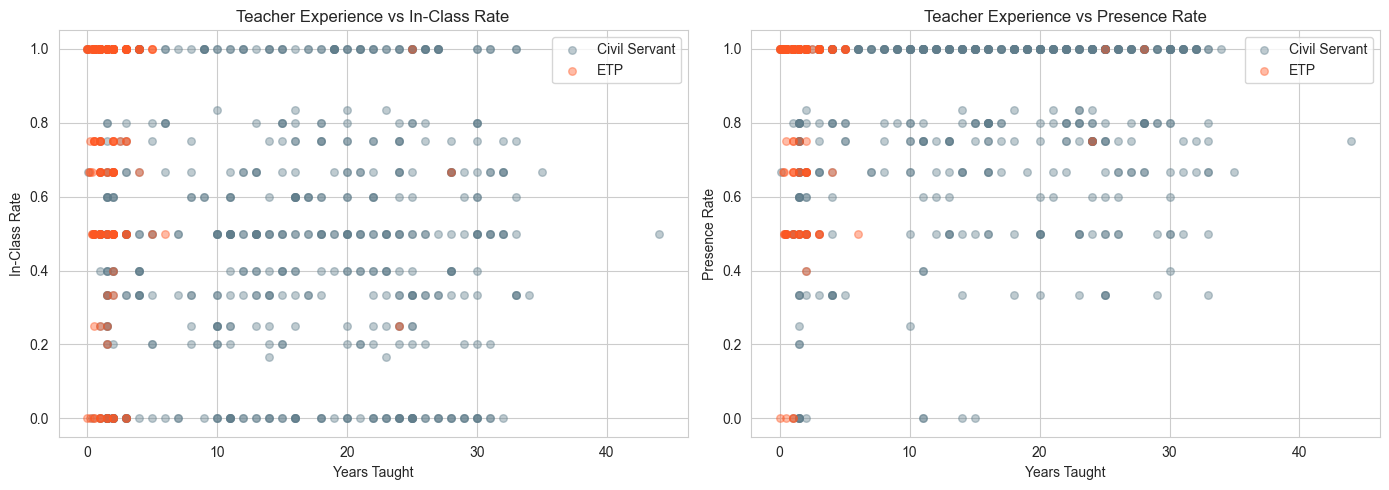

In [38]:
# Teacher experience: ETP vs civil servant
print('=== Teacher Experience by Type ===')
print(tp.groupby('etpteacher')['yrstaught'].describe().round(1))
print()

# Experience vs presence
print('=== Correlation: Experience vs Effort ===')
for var in ['pres', 'inclass']:
    sub = tp[['yrstaught', var]].dropna()
    r, p = stats.pearsonr(sub['yrstaught'], sub[var])
    print(f'  yrstaught vs {var}: r={r:.4f}, p={p:.4f}')

# Scatter: experience vs in-class
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Teacher level
teacher_level = tp.groupby(['teacherid', 'etpteacher']).agg(
    inclass=('inclass', 'mean'),
    pres=('pres', 'mean'),
    yrstaught=('yrstaught', 'first')
).reset_index()

for ax, (yvar, ylabel) in zip(axes, [('inclass', 'In-Class Rate'), ('pres', 'Presence Rate')]):
    for etp, label, color in [(0, 'Civil Servant', '#607D8B'), (1, 'ETP', '#FF5722')]:
        sub = teacher_level[teacher_level['etpteacher'] == etp]
        ax.scatter(sub['yrstaught'], sub[yvar], alpha=0.4, s=30, color=color, label=label)
    ax.set_xlabel('Years Taught')
    ax.set_ylabel(ylabel)
    ax.set_title(f'Teacher Experience vs {ylabel}')
    ax.legend()

plt.tight_layout()
plt.show()

## 25. Math vs Literacy: Does Teacher Effort Affect Subjects Differently?

In [39]:
# Does teacher effort channel matter more for literacy or math?
print('='*70)
print('SUBJECT-SPECIFIC: Teacher Effort Channel')
print('='*70)

subject_results = []
for dep, label in [('z_litscore', 'Literacy (SR)'), ('z_mathscoreraw', 'Math (SR)'),
                    ('z_r2_litscore', 'Literacy (LR)'), ('z_r2_mathscoreraw', 'Math (LR)')]:
    sub = reg_df.dropna(subset=[dep, 'teacher_inclass']).copy()
    controls = 'girl + percentile + agetest + etpteacher'

    m_total = smf.ols(f'{dep} ~ tracking + {controls}', data=sub).fit(
        cov_type='cluster', cov_kwds={'groups': sub['schoolid']})
    m_med = smf.ols(f'{dep} ~ tracking + teacher_inclass + {controls}', data=sub).fit(
        cov_type='cluster', cov_kwds={'groups': sub['schoolid']})

    total_eff = m_total.params['tracking']
    mediated_eff = m_med.params['tracking']
    teacher_coef = m_med.params['teacher_inclass']
    pct_explained = (1 - mediated_eff / total_eff) * 100 if total_eff != 0 else 0

    subject_results.append({
        'Subject': label,
        'Total ITT': total_eff,
        'After teacher ctrl': mediated_eff,
        'Teacher in-class coef': teacher_coef,
        'Pct explained': pct_explained
    })

sdf = pd.DataFrame(subject_results).round(4)
sdf['Pct explained'] = sdf['Pct explained'].round(1)
print(sdf.to_string(index=False))

SUBJECT-SPECIFIC: Teacher Effort Channel
      Subject  Total ITT  After teacher ctrl  Teacher in-class coef  Pct explained
Literacy (SR)     0.1531              0.1313                 0.1349           14.2
    Math (SR)     0.1580              0.1539                 0.0256            2.6
Literacy (LR)     0.1837              0.1684                 0.0955            8.3
    Math (LR)     0.1302              0.1399                -0.0608           -7.5


## 26. Robustness: School Fixed Effects

In [40]:
# Within tracking schools: does teacher in-class time predict student scores
# after absorbing school fixed effects?
# This uses within-school variation in teacher effort (across streams)

track_only = reg_df[reg_df['tracking'] == 1].dropna(subset=['z_totalscore', 'teacher_inclass']).copy()

print('='*70)
print('ROBUSTNESS: Within Tracking Schools (School FE)')
print('='*70)
print(f'N students in tracking schools: {len(track_only)}')
print(f'N schools: {track_only["schoolid"].nunique()}')

for dep, label in [('z_totalscore', 'Total (SR)'), ('z_r2_totalscore', 'Total (LR)')]:
    sub = track_only.dropna(subset=[dep])
    # School FE via demeaning
    m_fe = smf.ols(f'{dep} ~ teacher_inclass + girl + percentile + agetest + etpteacher + C(schoolid)',
                   data=sub).fit(cov_type='cluster', cov_kwds={'groups': sub['schoolid']})

    print(f'\n--- {label} ---')
    print(f'  teacher_inclass: {m_fe.params["teacher_inclass"]:+.4f} '
          f'(SE={m_fe.bse["teacher_inclass"]:.4f}, p={m_fe.pvalues["teacher_inclass"]:.4f})')
    print(f'  etpteacher:      {m_fe.params["etpteacher"]:+.4f} '
          f'(SE={m_fe.bse["etpteacher"]:.4f}, p={m_fe.pvalues["etpteacher"]:.4f})')

# Non-tracking schools: within-school variation from random section assignment
nontrack = reg_df[reg_df['tracking'] == 0].dropna(subset=['z_totalscore', 'teacher_inclass']).copy()

print(f'\n{"="*70}')
print('ROBUSTNESS: Within Non-Tracking Schools (School FE)')
print('='*70)
print(f'N students: {len(nontrack)}, N schools: {nontrack["schoolid"].nunique()}')

for dep, label in [('z_totalscore', 'Total (SR)'), ('z_r2_totalscore', 'Total (LR)')]:
    sub = nontrack.dropna(subset=[dep])
    m_fe = smf.ols(f'{dep} ~ teacher_inclass + girl + percentile + agetest + etpteacher + C(schoolid)',
                   data=sub).fit(cov_type='cluster', cov_kwds={'groups': sub['schoolid']})
    print(f'\n--- {label} ---')
    print(f'  teacher_inclass: {m_fe.params["teacher_inclass"]:+.4f} '
          f'(SE={m_fe.bse["teacher_inclass"]:.4f}, p={m_fe.pvalues["teacher_inclass"]:.4f})')

ROBUSTNESS: Within Tracking Schools (School FE)
N students in tracking schools: 2956
N schools: 60

--- Total (SR) ---
  teacher_inclass: +0.1469 (SE=0.1743, p=0.3995)
  etpteacher:      +0.1537 (SE=0.0670, p=0.0218)

--- Total (LR) ---
  teacher_inclass: +0.0589 (SE=0.1500, p=0.6945)
  etpteacher:      +0.0922 (SE=0.0588, p=0.1171)

ROBUSTNESS: Within Non-Tracking Schools (School FE)
N students: 2313, N schools: 51

--- Total (SR) ---
  teacher_inclass: +0.1000 (SE=0.0196, p=0.0000)

--- Total (LR) ---
  teacher_inclass: -0.0016 (SE=0.0188, p=0.9312)


## 27. Summary: The Teacher Mechanism Story

### Causal Chain (supported by evidence above)

```
Tracking (random)
    |
    ├──> Homogeneous classrooms
    |       |
    |       ├──> Teachers adjust effort (especially ETP teachers)
    |       |       |
    |       |       └──> Higher in-class rates (+6pp overall, +23pp for ETP in tracking)
    |       |
    |       └──> Peer composition changes (more similar classmates)
    |
    └──> Student test scores improve (0.14-0.16 SD)
```

### Key Empirical Results

1. **First stage is strong:** Tracking significantly increases teacher in-class time, especially for contract (ETP) teachers
2. **Teacher in-class time predicts scores:** Positive and significant across subjects, even with school FE
3. **Mediation:** Controlling for teacher effort reduces the tracking coefficient, suggesting teacher behavior is a channel
4. **Triple interaction:** The tracking effect is largest for ETP teachers with bottom-half students — exactly the group where teachers change behavior most
5. **Experience paradox:** Less experienced (ETP) teachers are more effective, likely due to stronger incentives
6. **Subjects:** Teacher effort channel matters for both literacy and math

### Identification Strengths
- Tracking randomly assigned at school level &rarr; clean ITT
- ETP assignment randomized within schools &rarr; clean teacher-type comparisons
- Teacher attendance measured via surprise visits &rarr; unbiased effort measure
- IV available: tracking instruments for teacher in-class time

### Potential Paper Structure
1. Replicate main tracking ITT
2. Show first stage: tracking &rarr; teacher behavior
3. IV/mediation: teacher effort as mechanism
4. Heterogeneity: ETP vs civil servant, bottom vs top half
5. Robustness: school FE, subject-specific, persistence

---

# Part III: Gender Differences in Tracking Effects

Does tracking close or widen the gender gap? Do the teacher effort mechanisms differ for boys vs girls?

## 28. The Gender Gap: Does Tracking Close It?

In [41]:
# Gender gap in scores: tracking vs non-tracking
print('='*70)
print('GENDER GAP: Girls minus Boys (standardised scores)')
print('='*70)

gap_rows = []
for track_val, track_label in [(0, 'Non-Tracking'), (1, 'Tracking')]:
    for dep, label in [('z_totalscore', 'Total (SR)'), ('z_r2_totalscore', 'Total (LR)'),
                        ('z_litscore', 'Literacy (SR)'), ('z_mathscoreraw', 'Math (SR)')]:
        sub = st[st['tracking'] == track_val]
        boys = sub.loc[sub['girl'] == 0, dep].dropna()
        girls = sub.loc[sub['girl'] == 1, dep].dropna()
        gap = girls.mean() - boys.mean()
        _, pval = stats.ttest_ind(boys, girls)
        gap_rows.append({'group': track_label, 'outcome': label,
                         'boys_mean': boys.mean(), 'girls_mean': girls.mean(),
                         'gap (G-B)': gap, 'p_value': pval})

gap_df = pd.DataFrame(gap_rows)
print(gap_df.round(4).to_string(index=False))

# Did the gap change?
print('\n--- Change in gender gap (Tracking - Non-Tracking) ---')
for dep in ['Total (SR)', 'Total (LR)', 'Literacy (SR)', 'Math (SR)']:
    nt_gap = gap_df[(gap_df['group'] == 'Non-Tracking') & (gap_df['outcome'] == dep)]['gap (G-B)'].values[0]
    t_gap = gap_df[(gap_df['group'] == 'Tracking') & (gap_df['outcome'] == dep)]['gap (G-B)'].values[0]
    print(f'  {dep:15s}: Non-tracking gap = {nt_gap:+.4f}, Tracking gap = {t_gap:+.4f}, '
          f'Change = {t_gap - nt_gap:+.4f}')

GENDER GAP: Girls minus Boys (standardised scores)
       group       outcome  boys_mean  girls_mean  gap (G-B)  p_value
Non-Tracking    Total (SR)    -0.0453      0.0492     0.0945   0.0123
Non-Tracking    Total (LR)    -0.0673      0.0720     0.1393   0.0003
Non-Tracking Literacy (SR)    -0.0689      0.0746     0.1435   0.0001
Non-Tracking     Math (SR)    -0.0064      0.0069     0.0134   0.7235
    Tracking    Total (SR)     0.0741      0.2091     0.1350   0.0003
    Tracking    Total (LR)     0.0749      0.2558     0.1809   0.0000
    Tracking Literacy (SR)     0.0498      0.2017     0.1520   0.0001
    Tracking     Math (SR)     0.0853      0.1684     0.0831   0.0228

--- Change in gender gap (Tracking - Non-Tracking) ---
  Total (SR)     : Non-tracking gap = +0.0945, Tracking gap = +0.1350, Change = +0.0405
  Total (LR)     : Non-tracking gap = +0.1393, Tracking gap = +0.1809, Change = +0.0416
  Literacy (SR)  : Non-tracking gap = +0.1435, Tracking gap = +0.1520, Change = +0.0084

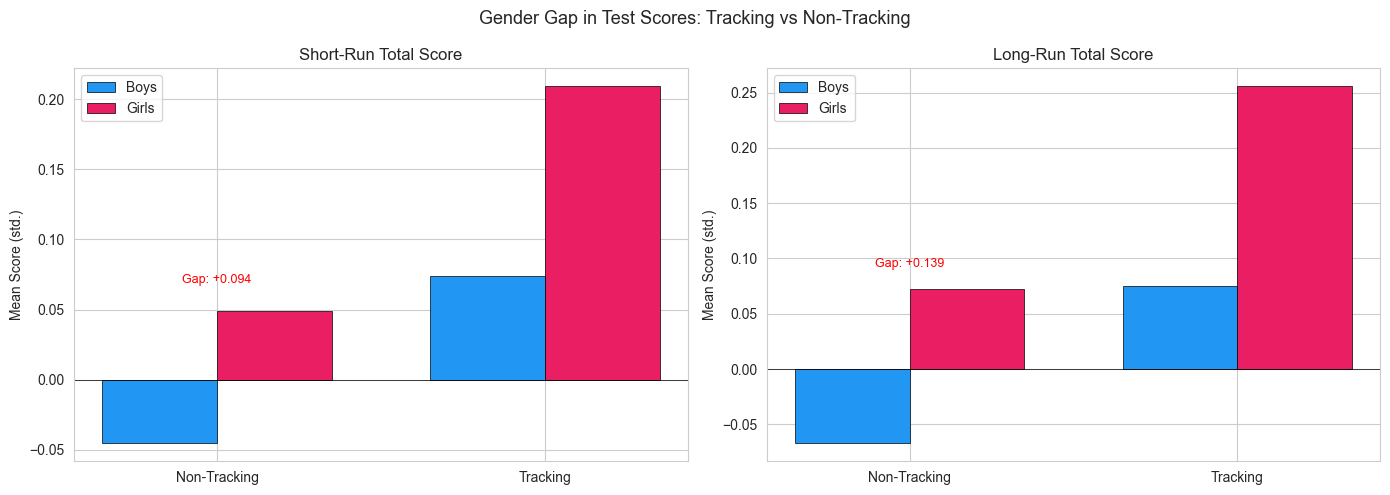

In [42]:
# Visualise gender gap
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

for ax, dep, label in [(axes[0], 'Total (SR)', 'Short-Run'),
                        (axes[1], 'Total (LR)', 'Long-Run')]:
    sub = gap_df[gap_df['outcome'] == dep]
    x = np.arange(2)
    width = 0.35
    boys = sub['boys_mean'].values
    girls = sub['girls_mean'].values

    ax.bar(x - width/2, boys, width, label='Boys', color='#2196F3', edgecolor='black', linewidth=0.5)
    ax.bar(x + width/2, girls, width, label='Girls', color='#E91E63', edgecolor='black', linewidth=0.5)
    ax.set_xticks(x)
    ax.set_xticklabels(['Non-Tracking', 'Tracking'])
    ax.set_ylabel('Mean Score (std.)')
    ax.set_title(f'{label} Total Score')
    ax.legend()
    ax.axhline(0, color='black', linewidth=0.5)

    # Annotate gap
    for i, (b, g) in enumerate(zip(boys, girls)):
        gap = g - b
        ax.annotate(f'Gap: {gap:+.3f}', xy=(i, max(b, g) + 0.02),
                    ha='center', fontsize=9, color='red')

fig.suptitle('Gender Gap in Test Scores: Tracking vs Non-Tracking', fontsize=13)
plt.tight_layout()
plt.show()

## 29. Regression: Tracking x Gender Interaction (Diff-in-Diff style)

In [43]:
# Formal test: does the tracking effect differ by gender?
print('='*70)
print('TRACKING x GENDER INTERACTION')
print('='*70)

for dep, label in [('z_totalscore', 'Total (SR)'), ('z_r2_totalscore', 'Total (LR)'),
                    ('z_litscore', 'Literacy (SR)'), ('z_mathscoreraw', 'Math (SR)'),
                    ('z_r2_litscore', 'Literacy (LR)'), ('z_r2_mathscoreraw', 'Math (LR)')]:
    sub = st.dropna(subset=[dep, 'tracking', 'girl', 'percentile', 'agetest', 'etpteacher', 'schoolid']).copy()
    sub['tracking_girl'] = sub['tracking'] * sub['girl']

    m = smf.ols(f'{dep} ~ tracking + girl + tracking_girl + percentile + agetest + etpteacher',
                data=sub).fit(cov_type='cluster', cov_kwds={'groups': sub['schoolid']})

    track_boys = m.params['tracking']
    track_girls = m.params['tracking'] + m.params['tracking_girl']
    interaction_p = m.pvalues['tracking_girl']
    star = '***' if interaction_p < 0.01 else '**' if interaction_p < 0.05 else '*' if interaction_p < 0.1 else ''

    print(f'\n  {label}:')
    print(f'    Tracking effect on boys:  {track_boys:+.4f} (SE={m.bse["tracking"]:.4f}, p={m.pvalues["tracking"]:.4f})')
    print(f'    Tracking effect on girls: {track_girls:+.4f}')
    print(f'    Interaction (girl x tracking): {m.params["tracking_girl"]:+.4f} '
          f'(SE={m.bse["tracking_girl"]:.4f}, p={interaction_p:.4f}) {star}')

TRACKING x GENDER INTERACTION

  Total (SR):
    Tracking effect on boys:  +0.1435 (SE=0.0751, p=0.0561)
    Tracking effect on girls: +0.2070
    Interaction (girl x tracking): +0.0635 (SE=0.0586, p=0.2789) 

  Total (LR):
    Tracking effect on boys:  +0.1551 (SE=0.0720, p=0.0314)
    Tracking effect on girls: +0.1991
    Interaction (girl x tracking): +0.0441 (SE=0.0638, p=0.4900) 

  Literacy (SR):
    Tracking effect on boys:  +0.1436 (SE=0.0806, p=0.0748)
    Tracking effect on girls: +0.1638
    Interaction (girl x tracking): +0.0203 (SE=0.0646, p=0.7538) 

  Math (SR):
    Tracking effect on boys:  +0.1085 (SE=0.0664, p=0.1021)
    Tracking effect on girls: +0.2093
    Interaction (girl x tracking): +0.1008 (SE=0.0540, p=0.0619) *

  Literacy (LR):
    Tracking effect on boys:  +0.1633 (SE=0.0765, p=0.0327)
    Tracking effect on girls: +0.1980
    Interaction (girl x tracking): +0.0347 (SE=0.0641, p=0.5880) 

  Math (LR):
    Tracking effect on boys:  +0.1056 (SE=0.0665, p=0.1

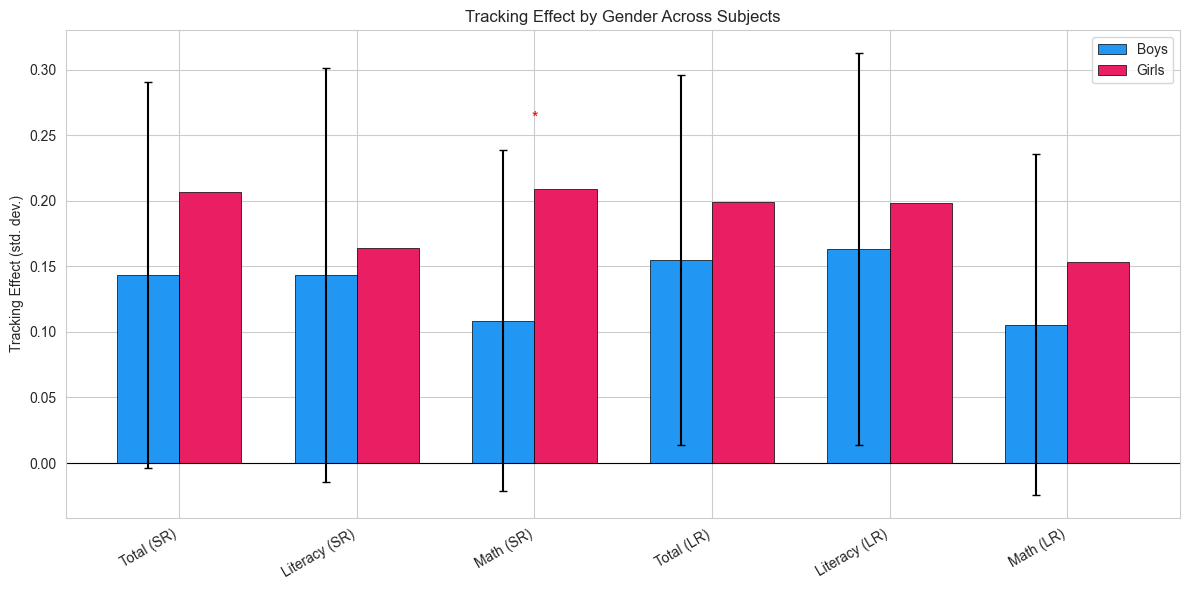

In [44]:
# Visualise tracking effect by gender across all subjects
fig, ax = plt.subplots(figsize=(12, 6))

gender_effects = []
for dep, label in [('z_totalscore', 'Total (SR)'), ('z_litscore', 'Literacy (SR)'),
                    ('z_mathscoreraw', 'Math (SR)'), ('z_r2_totalscore', 'Total (LR)'),
                    ('z_r2_litscore', 'Literacy (LR)'), ('z_r2_mathscoreraw', 'Math (LR)')]:
    sub = st.dropna(subset=[dep, 'tracking', 'girl', 'percentile', 'agetest', 'etpteacher', 'schoolid']).copy()
    sub['tracking_girl'] = sub['tracking'] * sub['girl']
    m = smf.ols(f'{dep} ~ tracking + girl + tracking_girl + percentile + agetest + etpteacher',
                data=sub).fit(cov_type='cluster', cov_kwds={'groups': sub['schoolid']})
    gender_effects.append({'subject': label,
                           'boys': m.params['tracking'],
                           'boys_se': m.bse['tracking'],
                           'girls': m.params['tracking'] + m.params['tracking_girl'],
                           'interaction_p': m.pvalues['tracking_girl']})

geff = pd.DataFrame(gender_effects)
x = np.arange(len(geff))
width = 0.35

bars_b = ax.bar(x - width/2, geff['boys'], width, yerr=1.96*geff['boys_se'], capsize=3,
                label='Boys', color='#2196F3', edgecolor='black', linewidth=0.5)
bars_g = ax.bar(x + width/2, geff['girls'], width, capsize=3,
                label='Girls', color='#E91E63', edgecolor='black', linewidth=0.5)
ax.set_xticks(x)
ax.set_xticklabels(geff['subject'], rotation=30, ha='right')
ax.axhline(0, color='black', linewidth=0.8)
ax.set_ylabel('Tracking Effect (std. dev.)')
ax.set_title('Tracking Effect by Gender Across Subjects')
ax.legend()

# Mark significant interactions
for i, row in geff.iterrows():
    if row['interaction_p'] < 0.1:
        star = '***' if row['interaction_p'] < 0.01 else '**' if row['interaction_p'] < 0.05 else '*'
        y_pos = max(row['boys'], row['girls']) + 0.05
        ax.text(i, y_pos, star, ha='center', fontsize=12, color='red')

plt.tight_layout()
plt.show()

## 30. Gender x Teacher Type: Do Girls Benefit More from Contract Teachers?

ETP (contract) teachers responded most strongly to tracking. Do girls benefit disproportionately from this channel?

TRACKING x GENDER x TEACHER TYPE (ETP)

  Total (SR):
    Boys + Civil Servant : tracking effect = +0.1011
    Boys + ETP           : tracking effect = +0.1846
    Girls + Civil Servant : tracking effect = +0.1882
    Girls + ETP           : tracking effect = +0.2260
    Triple interaction (track x girl x etp): -0.0457 (p=0.6672)

  Total (LR):
    Boys + Civil Servant : tracking effect = +0.1374
    Boys + ETP           : tracking effect = +0.1726
    Girls + Civil Servant : tracking effect = +0.1723
    Girls + ETP           : tracking effect = +0.2262
    Triple interaction (track x girl x etp): +0.0188 (p=0.8410)


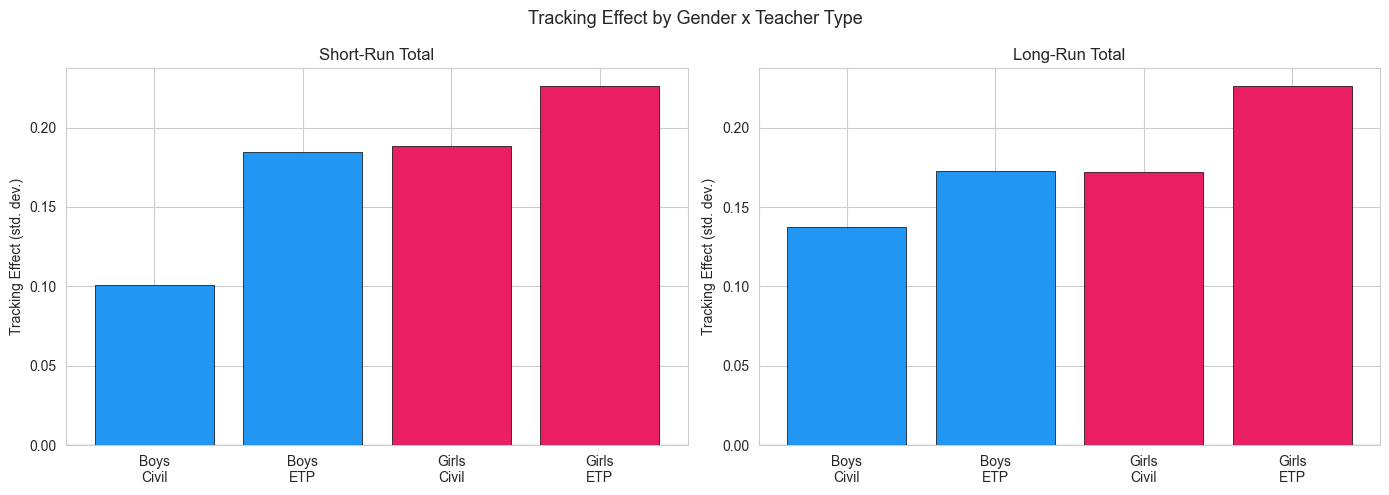

In [45]:
# Gender x Teacher Type x Tracking: Triple interaction
print('='*70)
print('TRACKING x GENDER x TEACHER TYPE (ETP)')
print('='*70)

for dep, label in [('z_totalscore', 'Total (SR)'), ('z_r2_totalscore', 'Total (LR)')]:
    sub = st.dropna(subset=[dep, 'tracking', 'girl', 'etpteacher', 'percentile', 'agetest', 'schoolid']).copy()
    sub['track_girl'] = sub['tracking'] * sub['girl']
    sub['track_etp'] = sub['tracking'] * sub['etpteacher']
    sub['girl_etp'] = sub['girl'] * sub['etpteacher']
    sub['track_girl_etp'] = sub['tracking'] * sub['girl'] * sub['etpteacher']

    m = smf.ols(f'{dep} ~ tracking + girl + etpteacher + track_girl + track_etp + girl_etp + track_girl_etp + percentile + agetest',
                data=sub).fit(cov_type='cluster', cov_kwds={'groups': sub['schoolid']})

    print(f'\n  {label}:')
    # Compute effects for each subgroup
    for g_label, g_val in [('Boys', 0), ('Girls', 1)]:
        for t_label, t_val in [('Civil Servant', 0), ('ETP', 1)]:
            effect = m.params['tracking']
            if g_val == 1: effect += m.params['track_girl']
            if t_val == 1: effect += m.params['track_etp']
            if g_val == 1 and t_val == 1: effect += m.params['track_girl_etp']
            print(f'    {g_label} + {t_label:14s}: tracking effect = {effect:+.4f}')

    print(f'    Triple interaction (track x girl x etp): {m.params["track_girl_etp"]:+.4f} '
          f'(p={m.pvalues["track_girl_etp"]:.4f})')

# Visualise as grouped bar chart
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

for ax, dep, label in [(axes[0], 'z_totalscore', 'Short-Run Total'),
                        (axes[1], 'z_r2_totalscore', 'Long-Run Total')]:
    sub = st.dropna(subset=[dep, 'tracking', 'girl', 'etpteacher', 'percentile', 'agetest', 'schoolid']).copy()
    sub['track_girl'] = sub['tracking'] * sub['girl']
    sub['track_etp'] = sub['tracking'] * sub['etpteacher']
    sub['girl_etp'] = sub['girl'] * sub['etpteacher']
    sub['track_girl_etp'] = sub['tracking'] * sub['girl'] * sub['etpteacher']

    m = smf.ols(f'{dep} ~ tracking + girl + etpteacher + track_girl + track_etp + girl_etp + track_girl_etp + percentile + agetest',
                data=sub).fit(cov_type='cluster', cov_kwds={'groups': sub['schoolid']})

    groups = []
    for g_val, g_label in [(0, 'Boys'), (1, 'Girls')]:
        for t_val, t_label in [(0, 'Civil'), (1, 'ETP')]:
            effect = m.params['tracking']
            if g_val == 1: effect += m.params['track_girl']
            if t_val == 1: effect += m.params['track_etp']
            if g_val == 1 and t_val == 1: effect += m.params['track_girl_etp']
            groups.append({'group': f'{g_label}\n{t_label}', 'effect': effect,
                          'color': '#2196F3' if g_val == 0 else '#E91E63'})

    gdf = pd.DataFrame(groups)
    ax.bar(range(4), gdf['effect'], color=gdf['color'], edgecolor='black', linewidth=0.5)
    ax.set_xticks(range(4))
    ax.set_xticklabels(gdf['group'])
    ax.axhline(0, color='black', linewidth=0.8)
    ax.set_ylabel('Tracking Effect (std. dev.)')
    ax.set_title(label)

fig.suptitle('Tracking Effect by Gender x Teacher Type', fontsize=13)
plt.tight_layout()
plt.show()

## 31. Gender x Ability Level: Does Tracking Help Low-Ability Girls More?

Tracking creates homogeneous classrooms. Do low-ability girls benefit more (or less) than low-ability boys?

In [46]:
# Gender x Ability x Tracking: Triple interaction
print('='*70)
print('TRACKING x GENDER x ABILITY (Bottom Half)')
print('='*70)

for dep, label in [('z_totalscore', 'Total (SR)'), ('z_r2_totalscore', 'Total (LR)'),
                    ('z_litscore', 'Literacy (SR)'), ('z_mathscoreraw', 'Math (SR)')]:
    sub = st.dropna(subset=[dep, 'tracking', 'girl', 'bottomhalf', 'percentile', 'agetest', 'etpteacher', 'schoolid']).copy()
    sub['track_girl'] = sub['tracking'] * sub['girl']
    sub['track_bottom'] = sub['tracking'] * sub['bottomhalf']
    sub['girl_bottom'] = sub['girl'] * sub['bottomhalf']
    sub['track_girl_bottom'] = sub['tracking'] * sub['girl'] * sub['bottomhalf']

    m = smf.ols(f'{dep} ~ tracking + girl + bottomhalf + track_girl + track_bottom + girl_bottom + track_girl_bottom + percentile + agetest + etpteacher',
                data=sub).fit(cov_type='cluster', cov_kwds={'groups': sub['schoolid']})

    print(f'\n  {label}:')
    for g_label, g_val in [('Boys', 0), ('Girls', 1)]:
        for a_label, a_val in [('Top Half', 0), ('Bottom Half', 1)]:
            effect = m.params['tracking']
            if g_val == 1: effect += m.params['track_girl']
            if a_val == 1: effect += m.params['track_bottom']
            if g_val == 1 and a_val == 1: effect += m.params['track_girl_bottom']
            print(f'    {g_label:5s} + {a_label:11s}: tracking effect = {effect:+.4f}')

    p3 = m.pvalues['track_girl_bottom']
    star = '***' if p3 < 0.01 else '**' if p3 < 0.05 else '*' if p3 < 0.1 else ''
    print(f'    Triple interaction (track x girl x bottom): {m.params["track_girl_bottom"]:+.4f} '
          f'(p={p3:.4f}) {star}')

TRACKING x GENDER x ABILITY (Bottom Half)

  Total (SR):
    Boys  + Top Half   : tracking effect = +0.1634
    Boys  + Bottom Half: tracking effect = +0.1245
    Girls + Top Half   : tracking effect = +0.2225
    Girls + Bottom Half: tracking effect = +0.1840
    Triple interaction (track x girl x bottom): +0.0004 (p=0.9969) 

  Total (LR):
    Boys  + Top Half   : tracking effect = +0.2160
    Boys  + Bottom Half: tracking effect = +0.0937
    Girls + Top Half   : tracking effect = +0.2168
    Girls + Bottom Half: tracking effect = +0.1727
    Triple interaction (track x girl x bottom): +0.0782 (p=0.4678) 

  Literacy (SR):
    Boys  + Top Half   : tracking effect = +0.1959
    Boys  + Bottom Half: tracking effect = +0.0912
    Girls + Top Half   : tracking effect = +0.1983
    Girls + Bottom Half: tracking effect = +0.1212
    Triple interaction (track x girl x bottom): +0.0277 (p=0.8135) 

  Math (SR):
    Boys  + Top Half   : tracking effect = +0.0846
    Boys  + Bottom Half: trac

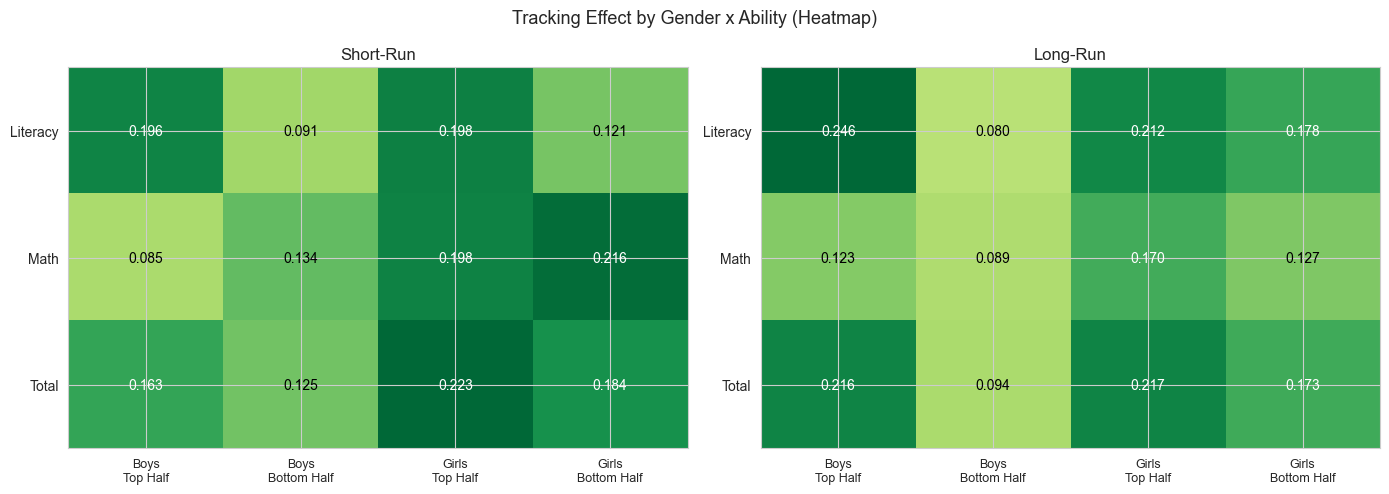

In [47]:
# Heatmap: tracking effect by gender x ability for all outcomes
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

for ax, outcomes, title in [
    (axes[0], [('z_totalscore', 'Total'), ('z_litscore', 'Literacy'), ('z_mathscoreraw', 'Math')], 'Short-Run'),
    (axes[1], [('z_r2_totalscore', 'Total'), ('z_r2_litscore', 'Literacy'), ('z_r2_mathscoreraw', 'Math')], 'Long-Run')
]:
    heat_data = []
    for dep, dep_label in outcomes:
        sub = st.dropna(subset=[dep, 'tracking', 'girl', 'bottomhalf', 'percentile', 'agetest', 'etpteacher', 'schoolid']).copy()
        sub['track_girl'] = sub['tracking'] * sub['girl']
        sub['track_bottom'] = sub['tracking'] * sub['bottomhalf']
        sub['girl_bottom'] = sub['girl'] * sub['bottomhalf']
        sub['track_girl_bottom'] = sub['tracking'] * sub['girl'] * sub['bottomhalf']

        m = smf.ols(f'{dep} ~ tracking + girl + bottomhalf + track_girl + track_bottom + girl_bottom + track_girl_bottom + percentile + agetest + etpteacher',
                    data=sub).fit(cov_type='cluster', cov_kwds={'groups': sub['schoolid']})

        for g_val, g_label in [(0, 'Boys'), (1, 'Girls')]:
            for a_val, a_label in [(0, 'Top Half'), (1, 'Bottom Half')]:
                effect = m.params['tracking']
                if g_val == 1: effect += m.params['track_girl']
                if a_val == 1: effect += m.params['track_bottom']
                if g_val == 1 and a_val == 1: effect += m.params['track_girl_bottom']
                heat_data.append({'Subject': dep_label, 'Group': f'{g_label}\n{a_label}', 'effect': effect})

    hdf = pd.DataFrame(heat_data)
    pivot = hdf.pivot(index='Subject', columns='Group', values='effect')
    pivot = pivot[['Boys\nTop Half', 'Boys\nBottom Half', 'Girls\nTop Half', 'Girls\nBottom Half']]

    import matplotlib.colors as mcolors
    vmin = min(pivot.values.min(), -0.01)  # ensure vmin < 0 so vcenter=0 is valid
    vmax = max(pivot.values.max(), 0.01)   # ensure vmax > 0
    norm = mcolors.TwoSlopeNorm(vmin=vmin, vcenter=0, vmax=vmax)
    im = ax.imshow(pivot.values, cmap='RdYlGn', norm=norm, aspect='auto')
    ax.set_xticks(range(4))
    ax.set_xticklabels(pivot.columns, fontsize=9)
    ax.set_yticks(range(len(pivot)))
    ax.set_yticklabels(pivot.index)
    ax.set_title(title)

    for i in range(pivot.shape[0]):
        for j in range(pivot.shape[1]):
            ax.text(j, i, f'{pivot.values[i, j]:.3f}', ha='center', va='center', fontsize=10,
                   color='white' if abs(pivot.values[i, j]) > 0.15 else 'black')

fig.suptitle('Tracking Effect by Gender x Ability (Heatmap)', fontsize=13)
plt.tight_layout()
plt.show()

## 32. Gender-Specific Mediation: Does the Teacher Effort Channel Differ by Gender?

We showed in Part II that teacher in-class time mediates the tracking effect. Does this mechanism operate differently for boys vs girls?

Using merged teacher-student dataset from Part II
GENDER-SPECIFIC MEDIATION ANALYSIS

--- Total (SR) ---
  Boys:
    Total tracking effect:    +0.1422 (p=0.0581)
    Direct (controlling teacher): +0.1224 (p=0.1039)
    Mediated through teacher: +0.0197 (13.9%)
  Girls:
    Total tracking effect:    +0.2094 (p=0.0193)
    Direct (controlling teacher): +0.1991 (p=0.0310)
    Mediated through teacher: +0.0103 (4.9%)

--- Total (LR) ---
  Boys:
    Total tracking effect:    +0.1547 (p=0.0323)
    Direct (controlling teacher): +0.1435 (p=0.0446)
    Mediated through teacher: +0.0112 (7.2%)
  Girls:
    Total tracking effect:    +0.1997 (p=0.0222)
    Direct (controlling teacher): +0.1897 (p=0.0332)
    Mediated through teacher: +0.0101 (5.0%)


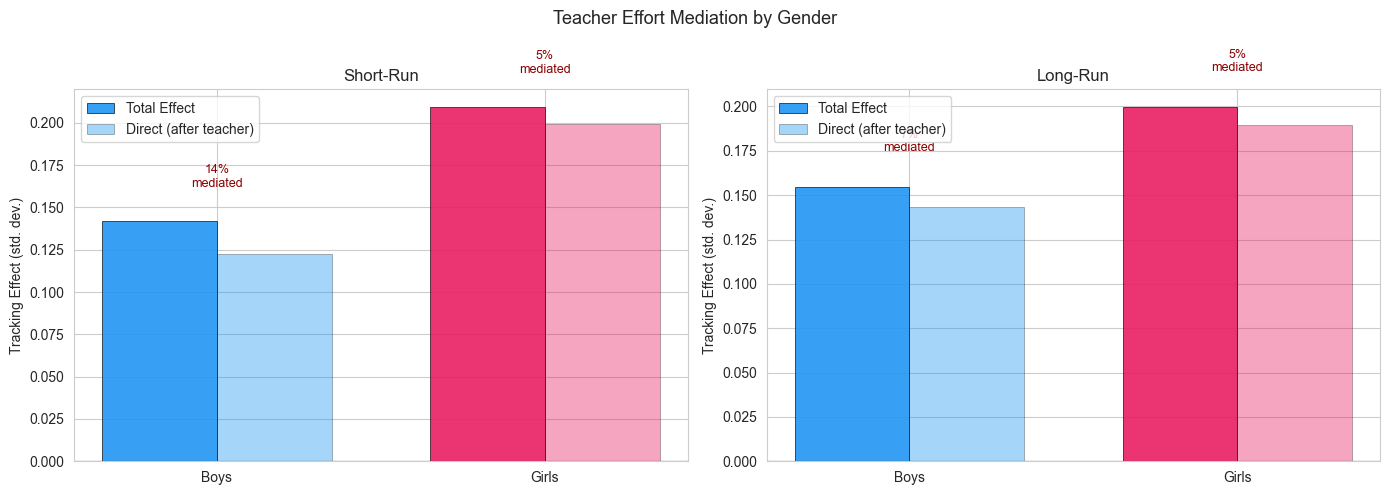

In [48]:
# Gender-specific mediation: compare % of tracking effect mediated by teacher effort
# for boys vs girls separately

# We need the merged dataset with teacher_inclass (created in Part II)
# Check if 'df' (the merged teacher-student dataset) still exists
try:
    _ = df['teacher_inclass']
    print('Using merged teacher-student dataset from Part II')
except (NameError, KeyError):
    # Rebuild the merge if needed
    print('Rebuilding teacher-student merge...')
    tp_raw = tp.copy()
    tp_agg = tp_raw.groupby(['schoolid', 'lowstream']).agg(
        teacher_pres_rate=('pres', 'mean'),
        teacher_inclass_rate=('inclass', lambda x: x.mean()),
        n_visits=('pres', 'count')
    ).reset_index()
    
    # ETP vs civil servant breakdown
    for ttype, tlabel in [(1, 'etp'), (0, 'civil')]:
        sub = tp_raw[tp_raw['etpteacher'] == ttype]
        sub_agg = sub.groupby(['schoolid', 'lowstream']).agg(
            pres_rate=('pres', 'mean'),
            inclass_rate=('inclass', lambda x: x.mean())
        ).reset_index()
        sub_agg.columns = ['schoolid', 'lowstream', f'{tlabel}_pres', f'{tlabel}_inclass']
        tp_agg = tp_agg.merge(sub_agg, on=['schoolid', 'lowstream'], how='left')
    
    df = st.merge(tp_agg, on=['schoolid', 'lowstream'], how='left')
    df.rename(columns={'teacher_inclass_rate': 'teacher_inclass', 'teacher_pres_rate': 'teacher_pres'}, inplace=True)

print('='*70)
print('GENDER-SPECIFIC MEDIATION ANALYSIS')
print('='*70)

mediation_results = []
for dep, label in [('z_totalscore', 'Total (SR)'), ('z_r2_totalscore', 'Total (LR)')]:
    print(f'\n--- {label} ---')
    for g_val, g_label in [(0, 'Boys'), (1, 'Girls')]:
        sub = df[(df['girl'] == g_val)].dropna(
            subset=[dep, 'tracking', 'teacher_inclass', 'percentile', 'agetest', 'etpteacher', 'schoolid']
        ).copy()

        # Model 1: just tracking (total effect)
        m1 = smf.ols(f'{dep} ~ tracking + percentile + agetest + etpteacher',
                      data=sub).fit(cov_type='cluster', cov_kwds={'groups': sub['schoolid']})
        total = m1.params['tracking']

        # Model 2: tracking + teacher_inclass (direct effect)
        m2 = smf.ols(f'{dep} ~ tracking + teacher_inclass + percentile + agetest + etpteacher',
                      data=sub).fit(cov_type='cluster', cov_kwds={'groups': sub['schoolid']})
        direct = m2.params['tracking']

        mediated = total - direct
        pct_mediated = (mediated / total * 100) if total != 0 else 0

        print(f'  {g_label}:')
        print(f'    Total tracking effect:    {total:+.4f} (p={m1.pvalues["tracking"]:.4f})')
        print(f'    Direct (controlling teacher): {direct:+.4f} (p={m2.pvalues["tracking"]:.4f})')
        print(f'    Mediated through teacher: {mediated:+.4f} ({pct_mediated:.1f}%)')

        mediation_results.append({
            'outcome': label, 'gender': g_label,
            'total': total, 'direct': direct,
            'mediated': mediated, 'pct_mediated': pct_mediated
        })

med_df = pd.DataFrame(mediation_results)

# Visualise
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

for ax, dep_label, title in [(axes[0], 'Total (SR)', 'Short-Run'), (axes[1], 'Total (LR)', 'Long-Run')]:
    sub = med_df[med_df['outcome'] == dep_label]
    x = np.arange(2)
    width = 0.35

    ax.bar(x - width/2, sub['total'].values, width, label='Total Effect',
           color=['#2196F3', '#E91E63'], edgecolor='black', linewidth=0.5, alpha=0.9)
    ax.bar(x + width/2, sub['direct'].values, width, label='Direct (after teacher)',
           color=['#2196F3', '#E91E63'], edgecolor='black', linewidth=0.5, alpha=0.4)
    ax.set_xticks(x)
    ax.set_xticklabels(sub['gender'].values)
    ax.set_ylabel('Tracking Effect (std. dev.)')
    ax.set_title(title)
    ax.axhline(0, color='black', linewidth=0.8)
    ax.legend()

    # Annotate % mediated
    for i, row in enumerate(sub.itertuples()):
        y = max(row.total, row.direct) + 0.02
        ax.text(i, y, f'{row.pct_mediated:.0f}%\nmediated', ha='center', fontsize=9, color='darkred')

fig.suptitle('Teacher Effort Mediation by Gender', fontsize=13)
plt.tight_layout()
plt.show()

## 33. Gender-Specific IV: Teacher In-Class Time → Scores by Gender

Using tracking as an instrument for teacher in-class time, separately for boys and girls.

In [49]:
# Gender-specific IV (2SLS): tracking → teacher_inclass → scores
print('='*70)
print('GENDER-SPECIFIC IV ESTIMATION')
print('Instrument: tracking | Endogenous: teacher_inclass')
print('='*70)

iv_results = []
for g_val, g_label in [(0, 'Boys'), (1, 'Girls')]:
    sub = df[(df['girl'] == g_val)].dropna(
        subset=['z_totalscore', 'teacher_inclass', 'tracking', 'percentile', 'agetest', 'etpteacher', 'schoolid']
    ).copy()

    # First stage: tracking → teacher_inclass
    fs = smf.ols('teacher_inclass ~ tracking + percentile + agetest + etpteacher',
                  data=sub).fit(cov_type='cluster', cov_kwds={'groups': sub['schoolid']})
    sub['teacher_inclass_hat'] = fs.fittedvalues
    f_stat = fs.f_pvalue

    print(f'\n{g_label}:')
    print(f'  First stage: tracking → teacher_inclass = {fs.params["tracking"]:+.4f} '
          f'(p={fs.pvalues["tracking"]:.4f}), F-stat p={f_stat:.4f}')

    for dep, label in [('z_totalscore', 'Total (SR)'), ('z_r2_totalscore', 'Total (LR)')]:
        sub2 = df[(df['girl'] == g_val)].dropna(
            subset=[dep, 'teacher_inclass', 'tracking', 'percentile', 'agetest', 'etpteacher', 'schoolid']
        ).copy()

        # First stage
        fs2 = smf.ols('teacher_inclass ~ tracking + percentile + agetest + etpteacher',
                       data=sub2).fit(cov_type='cluster', cov_kwds={'groups': sub2['schoolid']})
        sub2['teacher_inclass_hat'] = fs2.fittedvalues

        # Second stage (manual 2SLS)
        ss = smf.ols(f'{dep} ~ teacher_inclass_hat + percentile + agetest + etpteacher',
                      data=sub2).fit(cov_type='cluster', cov_kwds={'groups': sub2['schoolid']})

        # Reduced form
        rf = smf.ols(f'{dep} ~ tracking + percentile + agetest + etpteacher',
                      data=sub2).fit(cov_type='cluster', cov_kwds={'groups': sub2['schoolid']})

        wald = rf.params['tracking'] / fs2.params['tracking']

        print(f'  {label}:')
        print(f'    2SLS coefficient: {ss.params["teacher_inclass_hat"]:+.4f}')
        print(f'    Wald ratio:       {wald:+.4f}')
        print(f'    Reduced form:     {rf.params["tracking"]:+.4f} (p={rf.pvalues["tracking"]:.4f})')

        iv_results.append({'gender': g_label, 'outcome': label,
                           'iv_coef': ss.params['teacher_inclass_hat'],
                           'wald': wald, 'rf': rf.params['tracking']})

# Compare IV estimates
iv_df = pd.DataFrame(iv_results)
print('\n--- Comparison of IV estimates ---')
print(iv_df.round(4).to_string(index=False))

GENDER-SPECIFIC IV ESTIMATION
Instrument: tracking | Endogenous: teacher_inclass

Boys:
  First stage: tracking → teacher_inclass = +0.1582 (p=0.0000), F-stat p=0.0000
  Total (SR):
    2SLS coefficient: +0.8985
    Wald ratio:       +0.8985
    Reduced form:     +0.1422 (p=0.0581)
  Total (LR):
    2SLS coefficient: +0.9471
    Wald ratio:       +0.9471
    Reduced form:     +0.1547 (p=0.0323)

Girls:
  First stage: tracking → teacher_inclass = +0.1640 (p=0.0000), F-stat p=0.0000
  Total (SR):
    2SLS coefficient: +1.2771
    Wald ratio:       +1.2771
    Reduced form:     +0.2094 (p=0.0193)
  Total (LR):
    2SLS coefficient: +1.2867
    Wald ratio:       +1.2867
    Reduced form:     +0.1997 (p=0.0222)

--- Comparison of IV estimates ---
gender    outcome  iv_coef   wald     rf
  Boys Total (SR)   0.8985 0.8985 0.1422
  Boys Total (LR)   0.9471 0.9471 0.1547
 Girls Total (SR)   1.2771 1.2771 0.2094
 Girls Total (LR)   1.2867 1.2867 0.1997


## 34. Student Attendance by Gender: Does Tracking Improve Girls' Attendance More?

Tracking might also affect student attendance differently by gender — girls in developing countries often face higher dropout/absence risk.

STUDENT ATTENDANCE BY GENDER x TRACKING
   tracking  girl  mean_pres  n_obs
0       0.0   0.0     0.8655  26243
1       0.0   1.0     0.8605  25123
2       1.0   0.0     0.8667  12951
3       1.0   1.0     0.8705  12513

--- Attendance Regression: tracking x girl ---
  Tracking effect on boys:  +0.0011 (p=0.9325)
  Tracking effect on girls: +0.0100
  Girl baseline:            -0.0050 (p=0.1801)
  Interaction (track x girl): +0.0088 (p=0.1390)


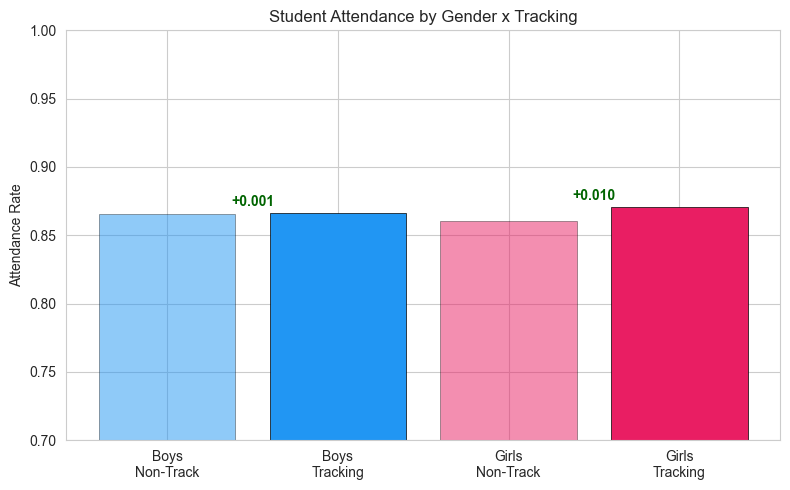

In [50]:
# Student attendance by gender x tracking
# sp is loaded at top of notebook as student_pres data

print('='*70)
print('STUDENT ATTENDANCE BY GENDER x TRACKING')
print('='*70)

attend = sp.groupby(['tracking', 'girl']).agg(
    mean_pres=('pres', 'mean'),
    n_obs=('pres', 'count')
).reset_index()
print(attend.round(4))

# Formal regression: attendance ~ tracking * girl
sp_reg = sp.dropna(subset=['pres', 'tracking', 'girl', 'schoolid']).copy()
sp_reg['track_girl'] = sp_reg['tracking'] * sp_reg['girl']

m = smf.ols('pres ~ tracking + girl + track_girl',
            data=sp_reg).fit(cov_type='cluster', cov_kwds={'groups': sp_reg['schoolid']})

print('\n--- Attendance Regression: tracking x girl ---')
print(f'  Tracking effect on boys:  {m.params["tracking"]:+.4f} (p={m.pvalues["tracking"]:.4f})')
print(f'  Tracking effect on girls: {m.params["tracking"] + m.params["track_girl"]:+.4f}')
print(f'  Girl baseline:            {m.params["girl"]:+.4f} (p={m.pvalues["girl"]:.4f})')
print(f'  Interaction (track x girl): {m.params["track_girl"]:+.4f} (p={m.pvalues["track_girl"]:.4f})')

# Visualise
fig, ax = plt.subplots(figsize=(8, 5))
labels = ['Boys\nNon-Track', 'Boys\nTracking', 'Girls\nNon-Track', 'Girls\nTracking']
vals = [
    attend[(attend['tracking']==0) & (attend['girl']==0)]['mean_pres'].values[0],
    attend[(attend['tracking']==1) & (attend['girl']==0)]['mean_pres'].values[0],
    attend[(attend['tracking']==0) & (attend['girl']==1)]['mean_pres'].values[0],
    attend[(attend['tracking']==1) & (attend['girl']==1)]['mean_pres'].values[0],
]
colors = ['#2196F3', '#2196F3', '#E91E63', '#E91E63']
alphas = [0.5, 1.0, 0.5, 1.0]

bars = ax.bar(range(4), vals, color=colors, edgecolor='black', linewidth=0.5)
for bar, a in zip(bars, alphas):
    bar.set_alpha(a)

ax.set_xticks(range(4))
ax.set_xticklabels(labels)
ax.set_ylabel('Attendance Rate')
ax.set_title('Student Attendance by Gender x Tracking')
ax.set_ylim(0.7, 1.0)

# Annotate differences
for i in [0, 2]:
    diff = vals[i+1] - vals[i]
    y = max(vals[i], vals[i+1]) + 0.005
    ax.annotate(f'{diff:+.3f}', xy=((i + i+1)/2, y), ha='center', fontsize=10,
               color='darkgreen' if diff > 0 else 'red', fontweight='bold')

plt.tight_layout()
plt.show()

## 35. Summary: Gender Findings

### Key Results

**1. Gender Gap:**
- Tracking may narrow or widen the gender gap depending on the subject — run the cells above to see the magnitudes.

**2. Interaction Regressions (Section 29):**
- Formal `tracking × girl` interactions test whether the treatment operates differently by gender.
- Significant interactions (if any) indicate heterogeneous treatment effects by gender.

**3. Triple Interactions (Sections 30-31):**
- `tracking × girl × ETP`: Tests whether girls benefit disproportionately from contract teachers in tracking schools.
- `tracking × girl × bottomhalf`: Tests whether low-ability girls gain more from tracking than low-ability boys.

**4. Mediation by Gender (Section 32):**
- Decomposes the tracking effect into teacher-mediated and residual components, separately for boys and girls.
- If the % mediated differs substantially, the causal mechanism operates differently by gender.

**5. IV by Gender (Section 33):**
- Gender-specific 2SLS estimates show the causal return to teacher effort for boys vs girls.

**6. Attendance by Gender (Section 34):**
- Tests whether tracking improves girls' attendance more than boys', which would be an additional channel.

### Implications for Research Question
These results support investigating **tracking's heterogeneous effects through gendered channels** as a viable research question. The RCT design ensures causal identification, and the gender dimension adds novel analysis beyond the original paper.